# Cluster Analysis

In [1]:
# Clustering test script for short static task

import csv
import pandas as pd
import numpy as np
import scipy as sp
import statistics
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from statsmodels.stats import weightstats as stests
from statsmodels.formula.api import ols
from sklearn.linear_model import Ridge
pd.set_option('display.max_rows', 2000)

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

## Setup

In [2]:
# Raw data filename
shortpath = Path(r"C:/Users/bbio/Documents/GrazianoLab/4-Correlates_of_Social_Cognition/shortened_static_awareness_task/data")
fn1 = "SSAT_070820_203subs.xlsx"
fn2 = "SSAT_RMET_HT_5.xlsx"

# Import data csv
df1_raw = pd.read_excel(shortpath / fn1,sheet_name="data",usecols="A:IF")
df2_raw = pd.read_excel(shortpath / fn2,sheet_name="SSAT",usecols="A:IF")
rmet1_raw = pd.read_excel(shortpath / fn1,sheet_name="rmet",usecols="A")
rmet2_raw = pd.read_excel(shortpath / fn2,sheet_name="RMET",usecols="A")
ht_raw = pd.read_excel(shortpath / fn2,sheet_name="HT")
#hte_raw = pd.read_excel(shortpath / fn2,sheet_name="HT_eval1",usecols="A")
hte_raw = pd.read_excel(shortpath / fn2,sheet_name="HT_WC1",usecols="A:B")

# Copy raw data to manipulate
df_temp = pd.concat([df1_raw,df2_raw],axis=0)
df_temp = df_temp.reset_index(drop=True)
rmet_temp = pd.concat([rmet1_raw,rmet2_raw],axis=0)
rmet_temp = rmet_temp.reset_index(drop=True)
#df_temp = pd.concat([df2_raw,rmet2_raw],axis=1)
ht_pretemp = pd.concat([ht_raw,hte_raw],axis=1)

naDiff = pd.to_numeric(rmet_temp.shape[0] - ht_pretemp.shape[0])

#df_na = pd.DataFrame(np.nan, index=range(0,naDiff), columns=['ht','ht_eval'])
df_na = pd.DataFrame(np.nan, index=range(0,naDiff), columns=['ht','ht_eval','WC_Avg'])

ht_temp = pd.concat([df_na,ht_pretemp],axis=0)
ht_temp = ht_temp.reset_index(drop=True)

# Copy raw data to manipulate
combined = pd.concat([df_temp,rmet_temp,ht_temp],axis=1)
combined = combined.reset_index(drop=True)

In [3]:
combined.shape

(831, 246)

In [4]:
combined.iloc[36,]

chalk_AAC           Somewhat Aware
wine_ATC            Somewhat Aware
door_HAI                Very Aware
tsunami_ATC         Somewhat Aware
sinkhole_AAC            Very Aware
building_HTI             Not Aware
carcrash_HAI        Somewhat Aware
hurricane_HTI           Very Aware
spider_ATC          Somewhat Aware
rottenorange_AAC    Somewhat Aware
lightning_ATC           Very Aware
arrow_HTI           Somewhat Aware
arrow_HAI           Somewhat Aware
knife_HTI                      NaN
brownie_HTC         Somewhat Aware
waffle_HTC                     NaN
candy_HAC                      NaN
fries_HTC               Very Aware
pizza_HAC           Somewhat Aware
scooter_ATI         Somewhat Aware
airhockey_AAI       Somewhat Aware
bubbles_HAC         Somewhat Aware
violin_ATI                     NaN
gift_ATI                       NaN
sunbeam_ATI         Somewhat Aware
flowers_HTC                    NaN
rose_HAC            Somewhat Aware
waterfall_HAC           Very Aware
door_ATC            

In [5]:
# Create subject list
subs = []

# Count subs
subCount = len(combined.index)

for x in range(1,subCount + 1):
    if x < 10:
        tmp = "s00" + str(x)
    elif 9 < x < 100:
        tmp = "s0" + str(x)
    elif x > 99: 
        tmp = "s" + str(x)
    subs.append(tmp)

# Add column with subject names
combined.insert(loc=0, column='sub', value=subs)

In [6]:
#combined[combined["sub"] == "s577"]

In [7]:
#exclSub = combined[ combined['sub'] == 's046' ].index
#combined.drop(exclSub , inplace=True)
exclSub2 = combined[ combined['ht_eval'] == 0 ].index
combined.drop(exclSub2, inplace=True)
exclSub3 = combined[ combined['ht'] == "na" ].index
combined.drop(exclSub3, inplace=True)
combined.shape

C:\Users\bbio\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


(677, 247)

In [8]:
exclSub2.shape

(154,)

In [9]:
# drop subs under 80% performance
#thresh80 = combined.dropna(thresh=192)
thresh80 = combined.dropna(thresh=195)

# Replace df with thresholded subs
ssat = thresh80.iloc[:,0:241]

# Reset indices (row names) to make up for dropped subs
df = ssat.reset_index(drop=True)

# Subset to match # of HT done
#df = df[:300]

# Pull out rmet from joint df
rmet = thresh80[['rmet']]

# Subset to match # of HT done
#rmet = rmet[:300]

# Reset indices (row names) to make up for dropped subs
rmet = rmet.reset_index(drop=True)

# Pull out ht from joint df
ht = thresh80[['ht']]

# Reset indices (row names) to make up for dropped subs
#ht.dropna(inplace=True)
ht = ht.reset_index(drop=True)
#ht =  ht.astype('int64')

hte = thresh80.iloc[:,242:245]
hte = hte.reset_index(drop=True)

In [10]:
thresh80.iloc[36]

sub                           s046
chalk_AAC           Somewhat Aware
wine_ATC                 Not Aware
door_HAI                Very Aware
tsunami_ATC         Somewhat Aware
sinkhole_AAC            Very Aware
building_HTI             Not Aware
carcrash_HAI            Very Aware
hurricane_HTI                  NaN
spider_ATC               Not Aware
rottenorange_AAC        Very Aware
lightning_ATC            Not Aware
arrow_HTI                Not Aware
arrow_HAI               Very Aware
knife_HTI           Somewhat Aware
brownie_HTC              Not Aware
waffle_HTC               Not Aware
candy_HAC               Very Aware
fries_HTC           Somewhat Aware
pizza_HAC               Very Aware
scooter_ATI              Not Aware
airhockey_AAI       Somewhat Aware
bubbles_HAC             Very Aware
violin_ATI               Not Aware
gift_ATI            Somewhat Aware
sunbeam_ATI              Not Aware
flowers_HTC             Very Aware
rose_HAC                Very Aware
waterfall_HAC       

In [11]:
na2_list = thresh80.isna().sum(axis=1)
nadf = pd.DataFrame(na2_list)
nadf.columns = ["NAs"]

In [12]:
hte

,ht,ht_eval,WC_Avg
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


In [13]:
# Subset data into fine grain categories
AAN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_AAC")]],axis=1)
AAP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_AAI")]],axis=1)
AHN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HAI")]],axis=1)
AHP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HAC")]],axis=1)
TAN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_ATC")]],axis=1)
TAP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_ATI")]],axis=1)
THN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HTI")]],axis=1)
THP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HTC")]],axis=1)

# Subset data into 4 main categories & create long-form versions of dfs
GNegENeg = pd.merge(AAP, AHN, on='sub')
GNegENeg.insert(loc=1, column='cond', value='GNegENeg')
GNegENeg_melted = pd.melt(GNegENeg,('sub','cond'),var_name='trial',value_name='rating')
GNegEPos = pd.merge(AAN, AHP, on='sub')
GNegEPos.insert(loc=1, column='cond', value='GNegEPos')
GNegEPos_melted = pd.melt(GNegEPos,('sub','cond'),var_name='trial',value_name='rating')
GPosENeg = pd.merge(TAP, THN, on='sub')
GPosENeg.insert(loc=1, column='cond', value='GPosENeg')
GPosENeg_melted = pd.melt(GPosENeg,('sub','cond'),var_name='trial',value_name='rating')
GPosEPos = pd.merge(TAN, THP, on='sub')
GPosEPos.insert(loc=1, column='cond', value='GPosEPos')
GPosEPos_melted = pd.melt(GPosEPos,('sub','cond'),var_name='trial',value_name='rating')

# Combine all conditions into one dataframe to plot
AllConds = pd.concat([GNegENeg_melted,GNegEPos_melted,GPosENeg_melted,GPosEPos_melted])

# Create numerical value dataframe
GnEn = GNegENeg.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GnEp = GNegEPos.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GpEn = GPosENeg.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GpEp = GPosEPos.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GnEn_sums = GnEn.sum(axis=1)
GnEp_sums = GnEp.sum(axis=1)
GpEn_sums = GpEn.sum(axis=1)
GpEp_sums = GpEp.sum(axis=1)
GnEn_means = GnEn.mean(axis=1)
GnEp_means = GnEp.mean(axis=1)
GpEn_means = GpEn.mean(axis=1)
GpEp_means = GpEp.mean(axis=1)

condSums = pd.DataFrame(columns=['GnEn', 'GnEp', 'GpEn', 'GpEp'])
condMeans = pd.DataFrame(columns=['GnEn', 'GnEp', 'GpEn', 'GpEp'])
subNum = len(df.index)

for n in range(1,subNum + 1):
    rowNum = n - 1
    a = GnEn_sums.iloc[rowNum]
    b = GnEp_sums.iloc[rowNum]
    c = GpEn_sums.iloc[rowNum]
    d = GpEp_sums.iloc[rowNum]
    condSums = condSums.append({'GnEn': a, 'GnEp': b, 'GpEn': c, 'GpEp': d}, ignore_index=True)

scs  = condSums/100

# setup df for condition means for each sub
for n in range(1,subNum + 1):
    rn = n - 1
    a2 = GnEn_means.iloc[rn]
    b2 = GnEp_means.iloc[rn]
    c2 = GpEn_means.iloc[rn]
    d2 = GpEp_means.iloc[rn]
    condMeans = condMeans.append({'GnEn': a2, 'GnEp': b2, 'GpEn': c2, 'GpEp': d2}, ignore_index=True)
cms = condMeans

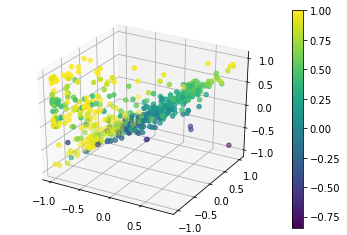

In [14]:
# 4D plot of conds
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = cms["GnEn"]
y = cms["GnEp"]
z = cms["GpEn"]
c = cms["GpEp"]

img = ax.scatter(x, y, z, c=c, cmap=plt.viridis())
fig.colorbar(img)
plt.show()
#fig.savefig('allsubs_4d_scatterplot.png')

## K-Means Clustering

In [15]:
km5 = KMeans(init='k-means++', n_clusters=5)
km5.fit(cms)
y_kmeans5 = km5.predict(cms)

## DF config and reordering

In [16]:
subList = thresh80[["sub"]]
subList = subList.reset_index(drop=True)
cluster_model5 = pd.DataFrame(y_kmeans5, columns=['clust'])
clustList5 = pd.concat([subList, cluster_model5, cms], axis=1)

In [17]:
allDF = pd.concat([clustList5, rmet, ht], axis=1)
allDF.shape

(588, 8)

In [18]:
allHT = allDF.copy()
allHT = allHT.dropna()
allHT["ht"] = pd.to_numeric(allHT["ht"])
allHT.shape

(411, 8)

In [19]:
allHTE = pd.concat([clustList5, rmet, hte], axis=1)
allHTE = allHTE.dropna()
allHTE["ht"] = pd.to_numeric(allHTE["ht"])
allHTE.shape

(411, 10)

In [20]:
allHTE

,sub,clust,GnEn,GnEp,GpEn,GpEp,rmet,ht,ht_eval,WC_Avg
177,s204,1,-0.965517,-0.310345,-0.054545,0.844828,29,20.0,1.0,8.3
178,s205,4,-1.000000,-0.542373,0.883333,1.000000,35,20.0,1.0,8.5
179,s206,4,-0.916667,-0.813559,1.000000,1.000000,31,18.0,1.0,11.5
180,s207,0,0.240741,0.333333,0.259259,0.102041,13,0.0,1.0,7.6
181,s209,2,-1.000000,0.169492,-0.844828,0.783333,27,20.0,1.0,7.0
182,s210,0,0.610169,0.568966,0.566667,0.566667,11,0.0,1.0,7.7
183,s211,1,-0.733333,-0.423729,-0.050000,0.932203,28,18.0,1.0,6.7
184,s213,3,-0.051724,-0.220339,0.033333,-0.017544,11,14.0,1.0,5.6
185,s215,0,0.288136,0.203704,0.333333,0.206897,12,0.0,1.0,7.2
186,s216,3,0.220339,0.017544,0.050000,0.216667,9,4.0,1.0,3.6


In [21]:
# Means by cluster
clust0a = allHTE[allHTE["clust"] == 0]
rc0 = clust0a["WC_Avg"]
hc0 = clust0a["ht"]
c0_rmean = round(rc0.mean(),2)
c0_hmean = round(hc0.mean(),2)
clust1a = allHTE[allHTE["clust"] == 1]
rc1 = clust1a["WC_Avg"]
hc1 = clust1a["ht"]
c1_rmean = round(rc1.mean(),2)
c1_hmean = round(hc1.mean(),2)
clust2a = allHTE[allHTE["clust"] == 2]
rc2 = clust2a["WC_Avg"]
hc2 = clust2a["ht"]
c2_rmean = round(rc2.mean(),2)
c2_hmean = round(hc2.mean(),2)
clust3a = allHTE[allHTE["clust"] == 3]
rc3 = clust3a["rmet"]
hc3 = clust3a["ht"]
c3_rmean = round(rc3.mean(),2)
c3_hmean = round(hc3.mean(),2)
clust4a = allHTE[allHTE["clust"] == 4]
rc4 = clust4a["WC_Avg"]
hc4 = clust4a["ht"]
c4_rmean = round(rc4.mean(),2)
c4_hmean = round(hc4.mean(),2)

print("clust1: WC mean = " + str(c1_rmean) + ", ht mean = " + str(c1_hmean))
print("clust2: WC mean = " + str(c2_rmean) + ", ht mean = " + str(c2_hmean))
print("clust3: WC mean = " + str(c3_rmean) + ", ht mean = " + str(c3_hmean))
print("clust4: WC mean = " + str(c4_rmean) + ", ht mean = " + str(c4_hmean))
print("clust0: WC mean = " + str(c0_rmean) + ", ht mean = " + str(c0_hmean))

clust1: WC mean = 7.6, ht mean = 16.7
clust2: WC mean = 7.4, ht mean = 16.1
clust3: WC mean = 14.54, ht mean = 5.08
clust4: WC mean = 7.53, ht mean = 15.61
clust0: WC mean = 7.7, ht mean = 2.76


In [22]:
# Means by cluster
clust0 = allDF[allDF["clust"] == 0]
clust0a = allHT[allHT["clust"] == 0]
rc0 = clust0["rmet"]
hc0 = clust0a["ht"]
c0_rmean = round(rc0.mean(),2)
c0_hmean = round(hc0.mean(),2)
clust1 = allDF[allDF["clust"] == 1]
clust1a = allHT[allHT["clust"] == 1]
rc1 = clust1["rmet"]
hc1 = clust1a["ht"]
c1_rmean = round(rc1.mean(),2)
c1_hmean = round(hc1.mean(),2)
clust2 = allDF[allDF["clust"] == 2]
clust2a = allHT[allHT["clust"] == 2]
rc2 = clust2["rmet"]
hc2 = clust2a["ht"]
c2_rmean = round(rc2.mean(),2)
c2_hmean = round(hc2.mean(),2)
clust3 = allDF[allDF["clust"] == 3]
clust3a = allHT[allHT["clust"] == 3]
rc3 = clust3["rmet"]
hc3 = clust3a["ht"]
c3_rmean = round(rc3.mean(),2)
c3_hmean = round(hc3.mean(),2)
clust4 = allDF[allDF["clust"] == 4]
clust4a = allHT[allHT["clust"] == 4]
rc4 = clust4["rmet"]
hc4 = clust4a["ht"]
c4_rmean = round(rc4.mean(),2)
c4_hmean = round(hc4.mean(),2)
rmeansdict = {
  "0": c0_rmean,
  "1": c1_rmean,
  "2": c2_rmean,
  "3": c3_rmean,
  "4": c4_rmean
}
print("clust1: rmet mean = " + str(c1_rmean) + ", ht mean = " + str(c1_hmean))
print("clust2: rmet mean = " + str(c2_rmean) + ", ht mean = " + str(c2_hmean))
print("clust3: rmet mean = " + str(c3_rmean) + ", ht mean = " + str(c3_hmean))
print("clust4: rmet mean = " + str(c4_rmean) + ", ht mean = " + str(c4_hmean))
print("clust0: rmet mean = " + str(c0_rmean) + ", ht mean = " + str(c0_hmean))

clust1: rmet mean = 27.38, ht mean = 16.7
clust2: rmet mean = 26.27, ht mean = 16.1
clust3: rmet mean = 14.31, ht mean = 5.08
clust4: rmet mean = 25.72, ht mean = 15.61
clust0: rmet mean = 12.98, ht mean = 2.76


In [23]:
# Copy dictionary
rMeansDict = rmeansdict.copy()
origMeansList = list(rMeansDict.values())
newMeansList = []
newMeansDict = {}
compMeansDict = {}

for cm in range(len(origMeansList)):
    currMin = min(origMeansList)
    newMeansDict[cm] = currMin
    origNum = list(rMeansDict.values()).index(currMin)
    compMeansDict[origNum] = cm
    origMeansList.remove(currMin)

#print(rMeansDict)
#print(newMeansDict)
#print(compMeansDict)

In [24]:
#ordered_allDF = allDF.replace({"clust": compMeansDict})
clustList5 = clustList5.replace({"clust": compMeansDict})
clustList5["clust"] += 1
new_clusts = list(clustList5["clust"])
allDF = allDF.replace({"clust": compMeansDict})
allDF["clust"] += 1
allHT = allDF.copy()
allHT = allHT.dropna()
allHT["ht"] = pd.to_numeric(allHT["ht"])
#allDF.to_csv('allDF.csv')

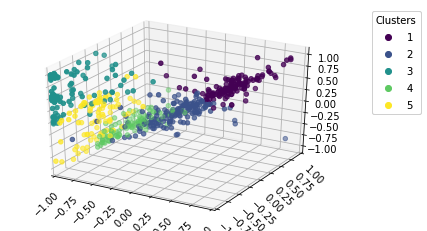

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = cms["GnEn"]
y = cms["GnEp"]
z = cms["GpEn"]
c = cms["GpEp"]

img = ax.scatter(x, y, z, c=new_clusts, cmap=plt.viridis())
legend1 = ax.legend(*img.legend_elements(), bbox_to_anchor=(1.25, 1), loc="upper right", title="Clusters")
ax.add_artist(legend1)
ax.tick_params(axis ='x', rotation =45)
ax.tick_params(axis ='y', rotation =-45)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
#plt.zlim(-1, 1)
#fig.colorbar(img)
plt.show()
#fig.savefig('figs/fig1_allsubs_kmeans_scatterplot.png', pad_inches=0.5, bbox_extra_artists=(legend1,), bbox_inches='tight')

### Avg Cluster Responses

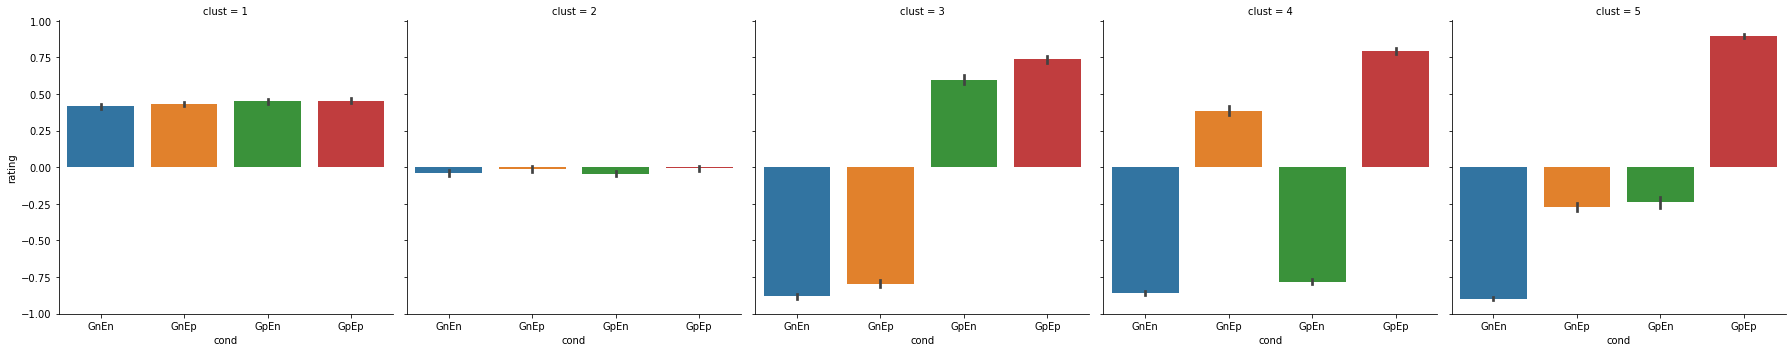

In [26]:
clst5_melt = pd.melt(clustList5,('sub','clust'),var_name='cond',value_name='rating')
g = sns.catplot(x="cond", y="rating", kind='bar', ci=68, col="clust", col_wrap=5, data=clst5_melt)
#plt.savefig('5clust_conds_barplot.png')
plt.tight_layout()
plt.savefig('figs/PaperFigs/avg_resp_barplot.pdf')

In [27]:
#test46 = clst5_melt[clst5_melt["sub"] == "s046"]
#g = sns.catplot(x="cond", y="rating", kind='bar', data=test46)
#plt.savefig('sub46_barplot.png')

In [28]:
# Means by cluster
clust1 = allDF[allDF["clust"] == 1]
clust1a = allHT[allHT["clust"] == 1]
c1_num = len(clust1)
c1a_num = len(clust1a)
print("Number of c1-rmet subs: " + str(c1_num))
print("Number of c1-ht subs: " + str(c1a_num))
rc1 = clust1["rmet"]
hc1 = clust1a["ht"]
c1_rmean = round(rc1.mean(),2)
c1_hmean = round(hc1.mean(),2)
c1_rsem = round(stats.sem(rc1),2)
c1_hsem = round(stats.sem(hc1),2)
print("clust1: rmet mean = " + str(c1_rmean) + ", ht mean = " + str(c1_hmean))
print("clust1: rmet sem = " + str(c1_rsem) + ", ht sem = " + str(c1_hsem))
###
clust2 = allDF[allDF["clust"] == 2]
clust2a = allHT[allHT["clust"] == 2]
c2_num = len(clust2)
c2a_num = len(clust2a)
print("Number of c2-rmet subs: " + str(c2_num))
print("Number of c2-ht subs: " + str(c2a_num))
rc2 = clust2["rmet"]
hc2 = clust2a["ht"]
c2_rmean = round(rc2.mean(),2)
c2_hmean = round(hc2.mean(),2)
c2_rsem = round(stats.sem(rc2),2)
c2_hsem = round(stats.sem(hc2),2)
print("clust2: rmet mean = " + str(c2_rmean) + ", ht mean = " + str(c2_hmean))
print("clust2: rmet sem = " + str(c2_rsem) + ", ht sem = " + str(c2_hsem))
###
clust3 = allDF[allDF["clust"] == 3]
clust3a = allHT[allHT["clust"] == 3]
c3_num = len(clust3)
c3a_num = len(clust3a)
print("Number of c3-rmet subs: " + str(c3_num))
print("Number of c3-ht subs: " + str(c3a_num))
rc3 = clust3["rmet"]
hc3 = clust3a["ht"]
c3_rmean = round(rc3.mean(),2)
c3_hmean = round(hc3.mean(),2)
c3_rsem = round(stats.sem(rc3),2)
c3_hsem = round(stats.sem(hc3),2)
print("clust3: rmet mean = " + str(c3_rmean) + ", ht mean = " + str(c3_hmean))
print("clust3: rmet sem = " + str(c3_rsem) + ", ht sem = " + str(c3_hsem))
###
clust4 = allDF[allDF["clust"] == 4]
clust4a = allHT[allHT["clust"] == 4]
c4_num = len(clust4)
c4a_num = len(clust4a)
print("Number of c4-rmet subs: " + str(c4_num))
print("Number of c4-ht subs: " + str(c4a_num))
rc4 = clust4["rmet"]
hc4 = clust4a["ht"]
c4_rmean = round(rc4.mean(),2)
c4_hmean = round(hc4.mean(),2)
c4_rsem = round(stats.sem(rc4),2)
c4_hsem = round(stats.sem(hc4),2)
print("clust4: rmet mean = " + str(c4_rmean) + ", ht mean = " + str(c4_hmean))
print("clust4: rmet sem = " + str(c4_rsem) + ", ht sem = " + str(c4_hsem))
###
clust5 = allDF[allDF["clust"] == 5]
clust5a = allHT[allHT["clust"] == 5]
c5_num = len(clust5)
c5a_num = len(clust5a)
print("Number of c5-rmet subs: " + str(c5_num))
print("Number of c5-ht subs: " + str(c5a_num))
rc5 = clust5["rmet"]
hc5 = clust5a["ht"]
c5_rmean = round(rc5.mean(),2)
c5_hmean = round(hc5.mean(),2)
c5_rsem = round(stats.sem(rc5),2)
c5_hsem = round(stats.sem(hc5),2)
print("clust5: rmet mean = " + str(c5_rmean) + ", ht mean = " + str(c5_hmean))
print("clust5: rmet sem = " + str(c5_rsem) + ", ht sem = " + str(c5_hsem))
###
print("Total # of rmet subs: " + str(sum([c1_num,c2_num,c3_num,c4_num,c5_num])))
print("Total # of ht subs: " + str(sum([c1a_num,c2a_num,c3a_num,c4a_num,c5a_num])))
rmeansdict = {
  "1": c1_rmean,
  "2": c2_rmean,
  "3": c3_rmean,
  "4": c4_rmean,
  "5": c5_rmean
}

Number of c1-rmet subs: 131
Number of c1-ht subs: 87
clust1: rmet mean = 12.98, ht mean = 2.76
clust1: rmet sem = 0.44, ht sem = 0.61
Number of c2-rmet subs: 151
Number of c2-ht subs: 111
clust2: rmet mean = 14.31, ht mean = 5.08
clust2: rmet sem = 0.37, ht sem = 0.61
Number of c3-rmet subs: 100
Number of c3-ht subs: 72
clust3: rmet mean = 25.72, ht mean = 15.61
clust3: rmet sem = 0.62, ht sem = 0.6
Number of c4-rmet subs: 115
Number of c4-ht subs: 78
clust4: rmet mean = 26.27, ht mean = 16.1
clust4: rmet sem = 0.54, ht sem = 0.6
Number of c5-rmet subs: 91
Number of c5-ht subs: 63
clust5: rmet mean = 27.38, ht mean = 16.7
clust5: rmet sem = 0.44, ht sem = 0.47
Total # of rmet subs: 588
Total # of ht subs: 411


In [29]:
rnonstrat = allDF.loc[(allDF["clust"] == 1) | (allDF["clust"] == 2), "rmet"]
rstrat = allDF.loc[(allDF["clust"] == 3) | (allDF["clust"] == 4) | (allDF["clust"] == 5), "rmet"]
hnonstrat = allDF.loc[(allDF["clust"] == 1) | (allDF["clust"] == 2), "ht"]
hstrat = allDF.loc[(allDF["clust"] == 3) | (allDF["clust"] == 4) | (allDF["clust"] == 5), "ht"]

In [30]:
print("Non-strategy, RMET")
print(rnonstrat.mean())
print(rnonstrat.std())
print("Strategy, RMET")
print(rstrat.mean())
print(rstrat.std())
print("Non-strategy, HT")
print(hnonstrat.mean())
print(hnonstrat.std())
print("Strategy, HT")
print(hstrat.mean())
print(hstrat.std())

Non-strategy, RMET
13.695035460992909
4.816110659532132
Strategy, RMET
26.42156862745098
5.507258294721885
Non-strategy, HT
4.0606060606060606
6.2434829889951535
Strategy, HT
16.112676056338028
4.792533390129788


### K-Means - RMET x cluster

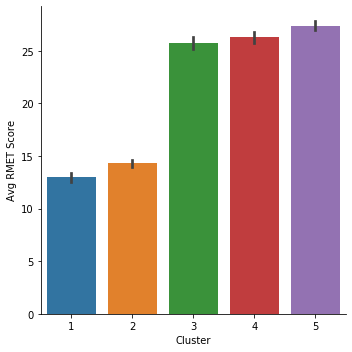

In [31]:
g = sns.catplot(x="clust", y="rmet", kind='bar', data=allDF, ci=68)
g.set(xlabel='Cluster', ylabel='Avg RMET Score')
plt.tight_layout()
plt.savefig('figs/PaperFigs/rmet_clust_barplot.pdf')

### K-Means - HT x cluster

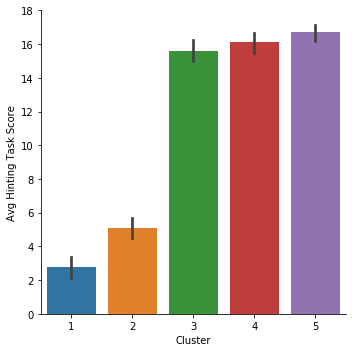

In [32]:
g = sns.catplot(x="clust", y="ht", kind='bar', data=allHT, ci=68)
g.set(xlabel='Cluster', ylabel='Avg Hinting Task Score')
plt.tight_layout()
plt.savefig('figs/PaperFigs/ht_clust_barplot.pdf')

## RMET x HT Correlation

(0.8147857572630741, 7.1356491361057355e-99)

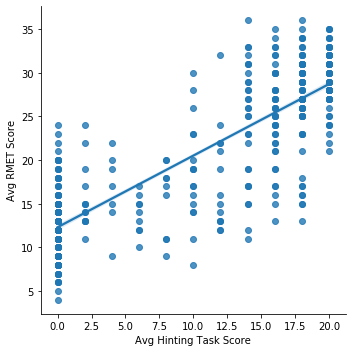

In [33]:
g = sns.lmplot(data=allHT, x="ht", y="rmet", ci=68)
stats.pearsonr(allHT["ht"],allHT["rmet"])
g.set(xlabel='Avg Hinting Task Score', ylabel='Avg RMET Score')
plt.tight_layout()
stats.pearsonr(allHT["ht"],allHT["rmet"])
#plt.savefig('figs/fig5_rmet_ht_scatterplot.png')

In [34]:
model = ols("allHT[\"ht\"] ~ allHT[\"rmet\"]", allHT).fit()
print(model.summary())
stats.pearsonr(allHT["ht"],allHT["rmet"])

                            OLS Regression Results                            
Dep. Variable:            allHT["ht"]   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     807.8
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           7.14e-99
Time:                        14:47:10   Log-Likelihood:                -1222.6
No. Observations:                 411   AIC:                             2449.
Df Residuals:                     409   BIC:                             2457.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.5273      0.637    -10.248

(0.8147857572630741, 7.1356491361057355e-99)

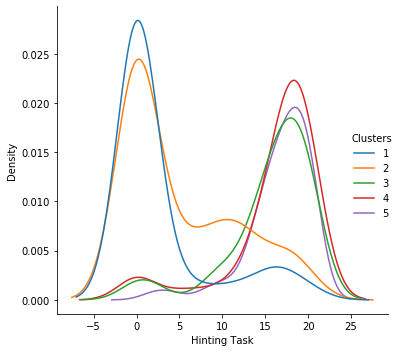

In [35]:
g = sns.displot(data=allHT, x="ht", hue="clust", kind="kde", palette="tab10")
g._legend.set_title("Clusters")
g.set(xlabel='Hinting Task')
plt.tight_layout()
#plt.savefig('figs/fig6_ht_clust_distplot.png')

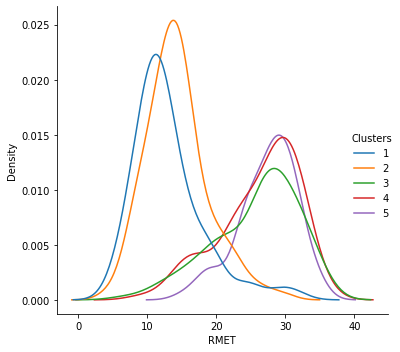

In [36]:
g = sns.displot(data=allDF, x="rmet", hue="clust", kind="kde", palette="tab10")
g._legend.set_title("Clusters")
g.set(xlabel='RMET')
plt.tight_layout()
#plt.savefig('figs/fig7_rmet_clust_distplot.png')

## Strategy Scores

In [37]:
# Difference sum of squares
vals = pd.DataFrame(columns=['intDiff', 'gazeDiff', 'exprDiff'])
subCount = len(allDF["sub"])
subList = allDF["sub"]
clstList = allDF["clust"]
i1 = -1
i2 = 0
i3 = 0
i4 = 1
g1 = -1
g2 = -1
g3 = 1
g4 = 1
e1 = -1
e2 = 1
e3 = -1
e4 = 1
for s in range(0,subCount):
    clst = clstList[s]
    currSub = subList[s]
    currRow = cms.iloc[s]
    c1 = currRow[0]
    c2 = currRow[1]
    c3 = currRow[2]
    c4 = currRow[3]
    iv1 = (i1-c1)**2
    iv2 = (i2-c2)**2
    iv3 = (i3-c3)**2
    iv4 = (i4-c4)**2
    ivSum = (iv1+iv2+iv3+iv4)
    ivFinal = round(ivSum,2)
    gv1 = (g1-c1)**2
    gv2 = (g2-c2)**2
    gv3 = (g3-c3)**2
    gv4 = (g4-c4)**2
    gvSum = (gv1+gv2+gv3+gv4)
    gvFinal = round(gvSum,2)
    ev1 = (e1-c1)**2
    ev2 = (e2-c2)**2
    ev3 = (e3-c3)**2
    ev4 = (e4-c4)**2
    evSum = (ev1+ev2+ev3+ev4)
    evFinal = round(evSum,2)
    tVals = [ivFinal,gvFinal,evFinal]
    tVals = pd.DataFrame(tVals).T
    tVals.columns = ['intDiff','gazeDiff','exprDiff']
    vals = pd.concat([vals, tVals])
    vals = vals.reset_index(drop=True)

In [38]:
cms

,GnEn,GnEp,GpEn,GpEp
0,-0.017544,0.050000,0.033898,0.071429
1,-0.933333,-0.310345,0.016667,1.000000
2,-0.964286,-0.224138,-0.385965,0.933333
3,-0.803922,0.750000,-0.791667,0.562500
4,-0.933333,-0.736842,0.677966,0.800000
5,-0.895833,-0.942308,0.420000,0.407407
6,0.362069,0.350877,0.357143,0.464286
7,-0.762712,-0.203390,-0.533333,0.633333
8,-0.542373,-0.508475,0.525424,0.542373
9,-0.833333,-0.200000,0.166667,0.916667


In [39]:
vals

,intDiff,gazeDiff,exprDiff
0,1.83,3.86,3.80
1,0.10,1.45,2.76
2,0.20,2.53,1.88
3,1.42,6.50,0.34
4,1.05,0.22,5.88
5,1.43,0.70,6.15
6,2.39,4.38,4.41
7,0.52,3.18,1.86
8,0.95,0.89,5.02
9,0.10,1.37,2.84


In [40]:
incallDF = pd.concat([allDF,vals],axis=1)
incallHT = pd.concat([allHT,vals],axis=1).dropna()
melt_incallDF = pd.melt(incallDF,('sub','clust','GnEn','GnEp','GpEn','GpEp','rmet','ht'),var_name='respType',value_name='val')
melt_incallHT = pd.melt(incallHT,('sub','clust','GnEn','GnEp','GpEn','GpEp','rmet','ht'),var_name='respType',value_name='val')

In [41]:
incallDF.to_excel("diffScores.xlsx")

In [42]:
c1_incallDF = incallDF[incallDF["clust"] == 1]
c2_incallDF = incallDF[incallDF["clust"] == 2]
c3_incallDF = incallDF[incallDF["clust"] == 3]
c4_incallDF = incallDF[incallDF["clust"] == 4]
c5_incallDF = incallDF[incallDF["clust"] == 5]

c1_incallHT = incallHT[incallHT["clust"] == 1]
c2_incallHT = incallHT[incallHT["clust"] == 2]
c3_incallHT = incallHT[incallHT["clust"] == 3]
c4_incallHT = incallHT[incallHT["clust"] == 4]
c5_incallHT = incallHT[incallHT["clust"] == 5]

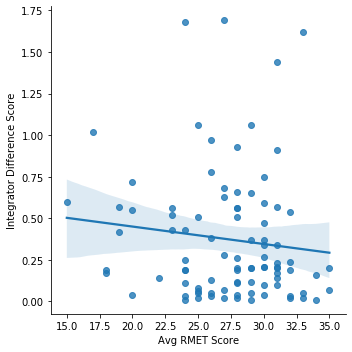

In [43]:
g = sns.lmplot(data=c5_incallDF, x="rmet", y="intDiff")
g.set(xlabel='Avg RMET Score', ylabel='Integrator Difference Score')
plt.tight_layout()

In [44]:
model = ols("c5_incallDF[\"rmet\"] ~ c5_incallDF[\"intDiff\"]", c5_incallDF).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     c5_incallDF["rmet"]   R-squared:                       0.013
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     1.190
Date:                 Tue, 24 Aug 2021   Prob (F-statistic):              0.278
Time:                         14:47:14   Log-Likelihood:                -258.84
No. Observations:                   91   AIC:                             521.7
Df Residuals:                       89   BIC:                             526.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

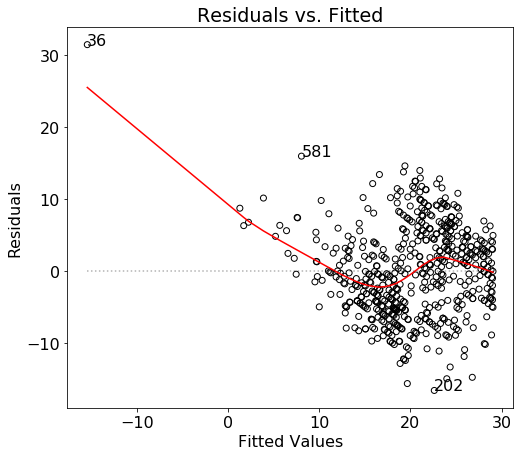

In [45]:
model = ols(formula='rmet ~ intDiff', data=incallDF).fit()
#print(model.summary())
residuals = model.resid
fitted = model.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

In [46]:
n_resid = residuals.drop(36)

In [47]:
n_fit = fitted.drop(36)

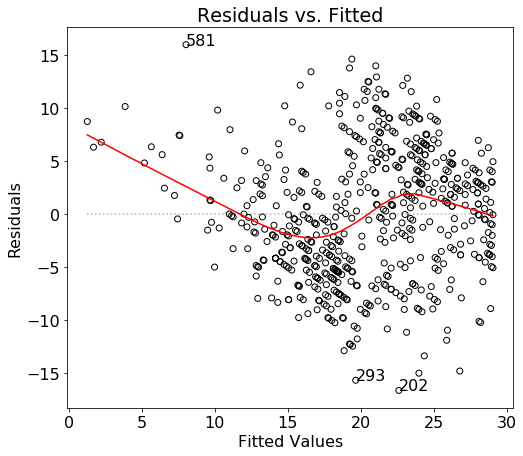

In [48]:
smoothed = lowess(n_resid,n_fit)
top3 = abs(n_resid).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(n_fit, n_resid, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(n_fit),max(n_fit)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(n_fit[i],n_resid[i]))

plt.show()

In [49]:
model = ols(formula='rmet ~ intDiff + gazeDiff + exprDiff', data=incallDF).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rmet   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     152.1
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           7.97e-73
Time:                        14:47:15   Log-Likelihood:                -1901.9
No. Observations:                 588   AIC:                             3812.
Df Residuals:                     584   BIC:                             3829.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7359    144.979     -0.040      0.9

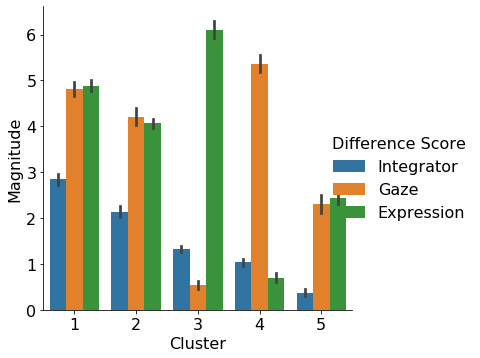

In [50]:
g = sns.catplot(x='clust',y='val',hue='respType', kind='bar',data = melt_incallDF, legend_out=True)
g.set(xlabel='Cluster', ylabel='Magnitude')
g._legend.set_title("Difference Score")
new_labels = ['Integrator', 'Gaze', 'Expression']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#plt.savefig('figs/fig8_diffscore_clust_barplot.png', pad_inches=0.25, bbox_extra_artists=(legend1,), bbox_inches='tight')

## Hinting Task Scatter Plots

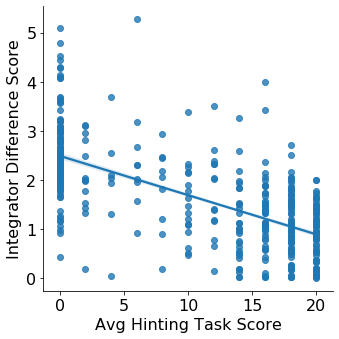

In [51]:
g = sns.lmplot(data=incallHT, x="ht", y="intDiff", ci=68)
g.set(xlabel='Avg Hinting Task Score', ylabel='Integrator Difference Score')
plt.tight_layout()
stats.pearsonr(incallHT["ht"],incallHT["intDiff"])
plt.savefig('figs/PaperFigs/ht_int_scatterplot.pdf')

In [52]:
# Fit the model
model = ols("incallHT[\"ht\"] ~ incallHT[\"intDiff\"]", incallHT).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         incallHT["ht"]   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     303.3
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           3.19e-51
Time:                        14:47:18   Log-Likelihood:                -1332.6
No. Observations:                 411   AIC:                             2669.
Df Residuals:                     409   BIC:                             2677.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              19.1992    

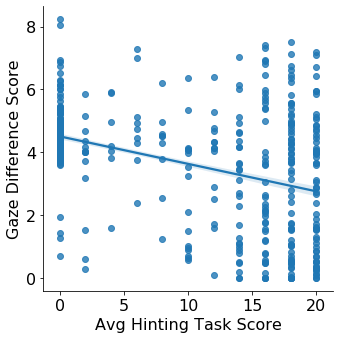

In [53]:
g = sns.lmplot(data=incallHT, x="ht", y="gazeDiff", ci=68)
g.set(xlabel='Avg Hinting Task Score', ylabel='Gaze Difference Score')
plt.tight_layout()
stats.pearsonr(incallHT["ht"],incallHT["gazeDiff"])
plt.savefig('figs/PaperFigs/ht_gaze_scatterplot.pdf')

In [54]:
# Fit the model
model = ols("incallHT[\"ht\"] ~ incallHT[\"gazeDiff\"]", incallHT).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         incallHT["ht"]   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     64.59
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           1.00e-14
Time:                        14:47:19   Log-Likelihood:                -1416.5
No. Observations:                 411   AIC:                             2837.
Df Residuals:                     409   BIC:                             2845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               15.9184 

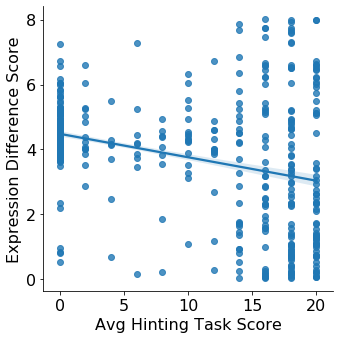

In [55]:
g = sns.lmplot(data=incallHT, x="ht", y="exprDiff", ci=68)
g.set(xlabel='Avg Hinting Task Score', ylabel='Expression Difference Score')
plt.tight_layout()
stats.pearsonr(incallHT["ht"],incallHT["exprDiff"])
plt.savefig('figs/PaperFigs/ht_expr_scatterplot.pdf')

In [56]:
# Fit the model
model = ols("incallHT[\"ht\"] ~ incallHT[\"exprDiff\"]", incallHT).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         incallHT["ht"]   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     39.94
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           6.84e-10
Time:                        14:47:20   Log-Likelihood:                -1427.5
No. Observations:                 411   AIC:                             2859.
Df Residuals:                     409   BIC:                             2867.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               14.9027 

## RMET Scatter Plots

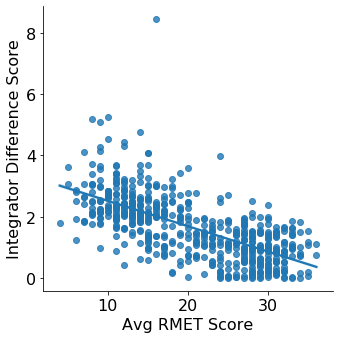

In [57]:
g = sns.lmplot(data=incallDF, x="rmet", y="intDiff", ci=68)
g.set(xlabel='Avg RMET Score', ylabel='Integrator Difference Score')
plt.tight_layout()
stats.pearsonr(incallDF["rmet"],incallDF["intDiff"])
plt.savefig('figs/PaperFigs/rmet_int_scatterplot.pdf')

In [58]:
# Fit the model
model = ols("incallDF[\"rmet\"] ~ incallDF[\"intDiff\"]", incallDF).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       incallDF["rmet"]   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     456.1
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           2.80e-75
Time:                        14:47:21   Log-Likelihood:                -1902.3
No. Observations:                 588   AIC:                             3809.
Df Residuals:                     586   BIC:                             3817.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              29.1186    

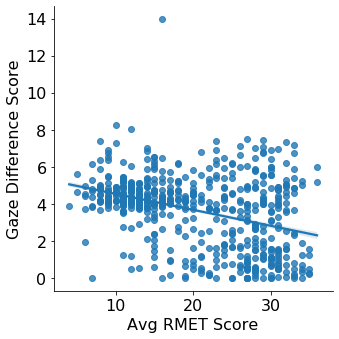

In [59]:
g = sns.lmplot(data=incallDF, x="rmet", y="gazeDiff", ci=68)
g.set(xlabel='Avg RMET Score', ylabel='Gaze Difference Score')
plt.tight_layout()
stats.pearsonr(incallDF["rmet"],incallDF["gazeDiff"])
plt.savefig('figs/PaperFigs/rmet_gaze_scatterplot.pdf')

In [60]:
# Fit the model
model = ols("incallDF[\"rmet\"] ~ incallDF[\"gazeDiff\"]", incallDF).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       incallDF["rmet"]   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     89.78
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           6.50e-20
Time:                        14:47:22   Log-Likelihood:                -2029.7
No. Observations:                 588   AIC:                             4063.
Df Residuals:                     586   BIC:                             4072.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               25.9488 

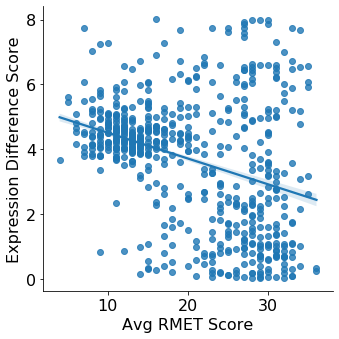

In [61]:
g = sns.lmplot(data=incallDF, x="rmet", y="exprDiff", ci=68)
g.set(xlabel='Avg RMET Score', ylabel='Expression Difference Score')
plt.tight_layout()
stats.pearsonr(incallDF["rmet"],incallDF["exprDiff"])
plt.savefig('figs/PaperFigs/rmet_expr_scatterplot.pdf')

In [62]:
# Fit the model
model = ols("incallDF[\"rmet\"] ~ incallDF[\"exprDiff\"]", incallDF).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       incallDF["rmet"]   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     72.30
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           1.54e-16
Time:                        14:47:23   Log-Likelihood:                -2037.4
No. Observations:                 588   AIC:                             4079.
Df Residuals:                     586   BIC:                             4087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               25.4000 

In [63]:
c1_int = stats.pearsonr(c1_incallHT["ht"],c1_incallHT["intDiff"])
print("Clust 1 HTxIntegrator, r = " + str(round(c1_int[0],2)) + ", p = " + str(round(c1_int[1],2)))
c1_gaze = stats.pearsonr(c1_incallHT["ht"],c1_incallHT["gazeDiff"])
print("Clust 1 HTxGaze, r = " + str(round(c1_gaze[0],2)) + ", p = " + str(round(c1_gaze[1],2)))
c1_expr = stats.pearsonr(c1_incallHT["ht"],c1_incallHT["exprDiff"])
print("Clust 1 HTxExpression, r = " + str(round(c1_expr[0],2)) + ", p = " + str(round(c1_expr[1],2)))
print("+++++")
c2_int = stats.pearsonr(c2_incallHT["ht"],c2_incallHT["intDiff"])
print("Clust 2 HTxIntegrator, r = " + str(round(c2_int[0],2)) + ", p = " + str(round(c2_int[1],2)))
c2_gaze = stats.pearsonr(c2_incallHT["ht"],c2_incallHT["gazeDiff"])
print("Clust 2 HTxGaze, r = " + str(round(c2_gaze[0],2)) + ", p = " + str(round(c2_gaze[1],2)))
c2_expr = stats.pearsonr(c2_incallHT["ht"],c2_incallHT["exprDiff"])
print("Clust 2 HTxExpression, r = " + str(round(c2_expr[0],2)) + ", p = " + str(round(c2_expr[1],2)))
print("+++++")
c3_int = stats.pearsonr(c3_incallHT["ht"],c3_incallHT["intDiff"])
print("Clust 3 HTxIntegrator, r = " + str(round(c3_int[0],2)) + ", p = " + str(round(c3_int[1],2)))
c3_gaze = stats.pearsonr(c3_incallHT["ht"],c3_incallHT["gazeDiff"])
print("Clust 3 HTxGaze, r = " + str(round(c3_gaze[0],2)) + ", p = " + str(round(c3_gaze[1],2)))
c3_expr = stats.pearsonr(c3_incallHT["ht"],c3_incallHT["exprDiff"])
print("Clust 3 HTxExpression, r = " + str(round(c3_expr[0],2)) + ", p = " + str(round(c3_expr[1],2)))
print("+++++")
c4_int = stats.pearsonr(c4_incallHT["ht"],c4_incallHT["intDiff"])
print("Clust 4 HTxIntegrator, r = " + str(round(c4_int[0],2)) + ", p = " + str(round(c4_int[1],2)))
c4_gaze = stats.pearsonr(c4_incallHT["ht"],c4_incallHT["gazeDiff"])
print("Clust 4 HTxGaze, r = " + str(round(c4_gaze[0],2)) + ", p = " + str(round(c4_gaze[1],2)))
c4_expr = stats.pearsonr(c4_incallHT["ht"],c4_incallHT["exprDiff"])
print("Clust 4 HTxExpression, r = " + str(round(c4_expr[0],2)) + ", p = " + str(round(c4_expr[1],2)))
print("+++++")
c5_int = stats.pearsonr(c5_incallHT["ht"],c5_incallHT["intDiff"])
print("Clust 5 HTxIntegrator, r = " + str(round(c5_int[0],2)) + ", p = " + str(round(c5_int[1],2)))
c5_gaze = stats.pearsonr(c5_incallHT["ht"],c5_incallHT["gazeDiff"])
print("Clust 5 HTxGaze, r = " + str(round(c5_gaze[0],2)) + ", p = " + str(round(c5_gaze[1],2)))
c5_expr = stats.pearsonr(c5_incallHT["ht"],c5_incallHT["exprDiff"])
print("Clust 5 HTxExpression, r = " + str(round(c5_expr[0],2)) + ", p = " + str(round(c5_expr[1],2)))

Clust 1 HTxIntegrator, r = -0.27, p = 0.01
Clust 1 HTxGaze, r = -0.37, p = 0.0
Clust 1 HTxExpression, r = -0.09, p = 0.41
+++++
Clust 2 HTxIntegrator, r = -0.29, p = 0.0
Clust 2 HTxGaze, r = -0.19, p = 0.05
Clust 2 HTxExpression, r = -0.3, p = 0.0
+++++
Clust 3 HTxIntegrator, r = 0.18, p = 0.12
Clust 3 HTxGaze, r = -0.38, p = 0.0
Clust 3 HTxExpression, r = 0.27, p = 0.02
+++++
Clust 4 HTxIntegrator, r = -0.2, p = 0.09
Clust 4 HTxGaze, r = -0.1, p = 0.38
Clust 4 HTxExpression, r = -0.1, p = 0.38
+++++
Clust 5 HTxIntegrator, r = 0.1, p = 0.43
Clust 5 HTxGaze, r = 0.13, p = 0.29
Clust 5 HTxExpression, r = -0.05, p = 0.72


In [64]:
rc1_int = stats.pearsonr(c1_incallDF["rmet"],c1_incallDF["intDiff"])
print("Clust 1 rmetxIntegrator, r = " + str(round(rc1_int[0],2)) + ", p = " + str(round(rc1_int[1],2)))
rc1_gaze = stats.pearsonr(c1_incallDF["rmet"],c1_incallDF["gazeDiff"])
print("Clust 1 rmetxGaze, r = " + str(round(rc1_gaze[0],2)) + ", p = " + str(round(rc1_gaze[1],2)))
rc1_expr = stats.pearsonr(c1_incallDF["rmet"],c1_incallDF["exprDiff"])
print("Clust 1 rmetxExpression, r = " + str(round(rc1_expr[0],2)) + ", p = " + str(round(rc1_expr[1],2)))
print("+++++")
rc2_int = stats.pearsonr(c2_incallDF["rmet"],c2_incallDF["intDiff"])
print("Clust 2 rmetxIntegrator, r = " + str(round(rc2_int[0],2)) + ", p = " + str(round(rc2_int[1],2)))
rc2_gaze = stats.pearsonr(c2_incallDF["rmet"],c2_incallDF["gazeDiff"])
print("Clust 2 rmetxGaze, r = " + str(round(rc2_gaze[0],2)) + ", p = " + str(round(rc2_gaze[1],2)))
rc2_expr = stats.pearsonr(c2_incallDF["rmet"],c2_incallDF["exprDiff"])
print("Clust 2 rmetxExpression, r = " + str(round(rc2_expr[0],2)) + ", p = " + str(round(rc2_expr[1],2)))
print("+++++")
rc3_int = stats.pearsonr(c3_incallDF["rmet"],c3_incallDF["intDiff"])
print("Clust 3 rmetxIntegrator, r = " + str(round(rc3_int[0],2)) + ", p = " + str(round(rc3_int[1],2)))
rc3_gaze = stats.pearsonr(c3_incallDF["rmet"],c3_incallDF["gazeDiff"])
print("Clust 3 rmetxGaze, r = " + str(round(rc3_gaze[0],2)) + ", p = " + str(round(rc3_gaze[1],2)))
rc3_expr = stats.pearsonr(c3_incallDF["rmet"],c3_incallDF["exprDiff"])
print("Clust 3 rmetxExpression, r = " + str(round(rc3_expr[0],2)) + ", p = " + str(round(rc3_expr[1],2)))
print("+++++")
rc4_int = stats.pearsonr(c4_incallDF["rmet"],c4_incallDF["intDiff"])
print("Clust 4 rmetxIntegrator, r = " + str(round(rc4_int[0],2)) + ", p = " + str(round(rc4_int[1],2)))
rc4_gaze = stats.pearsonr(c4_incallDF["rmet"],c4_incallDF["gazeDiff"])
print("Clust 4 rmetxGaze, r = " + str(round(rc4_gaze[0],2)) + ", p = " + str(round(rc4_gaze[1],2)))
rc4_expr = stats.pearsonr(c4_incallDF["rmet"],c4_incallDF["exprDiff"])
print("Clust 4 rmetxExpression, r = " + str(round(rc4_expr[0],2)) + ", p = " + str(round(rc4_expr[1],2)))
print("+++++")
rc5_int = stats.pearsonr(c5_incallDF["rmet"],c5_incallDF["intDiff"])
print("Clust 5 rmetxIntegrator, r = " + str(round(rc5_int[0],2)) + ", p = " + str(round(rc5_int[1],2)))
rc5_gaze = stats.pearsonr(c5_incallDF["rmet"],c5_incallDF["gazeDiff"])
print("Clust 5 rmetxGaze, r = " + str(round(rc5_gaze[0],2)) + ", p = " + str(round(rc5_gaze[1],2)))
rc5_expr = stats.pearsonr(c5_incallDF["rmet"],c5_incallDF["exprDiff"])
print("Clust 5 rmetxExpression, r = " + str(round(rc5_expr[0],2)) + ", p = " + str(round(rc5_expr[1],2)))

Clust 1 rmetxIntegrator, r = -0.35, p = 0.0
Clust 1 rmetxGaze, r = -0.4, p = 0.0
Clust 1 rmetxExpression, r = -0.19, p = 0.03
+++++
Clust 2 rmetxIntegrator, r = -0.08, p = 0.34
Clust 2 rmetxGaze, r = 0.01, p = 0.95
Clust 2 rmetxExpression, r = -0.2, p = 0.01
+++++
Clust 3 rmetxIntegrator, r = -0.06, p = 0.57
Clust 3 rmetxGaze, r = -0.25, p = 0.01
Clust 3 rmetxExpression, r = 0.06, p = 0.55
+++++
Clust 4 rmetxIntegrator, r = -0.14, p = 0.12
Clust 4 rmetxGaze, r = -0.07, p = 0.44
Clust 4 rmetxExpression, r = -0.08, p = 0.41
+++++
Clust 5 rmetxIntegrator, r = -0.11, p = 0.28
Clust 5 rmetxGaze, r = -0.21, p = 0.04
Clust 5 rmetxExpression, r = 0.13, p = 0.2


## Median splits

In [65]:
allDF_med = statistics.median(allDF["rmet"])
lwr_allDF = allDF[allDF.rmet <= allDF_med]
rmet_lwr = lwr_allDF.drop(columns=['rmet', 'ht'])
gtr_allDF = allDF[allDF.rmet > allDF_med]
rmet_gtr = gtr_allDF.drop(columns=['rmet', 'ht'])
rmet_gtr_melt = pd.melt(rmet_gtr,('sub','clust'),var_name='cond',value_name='rating')
rmet_lwr_melt = pd.melt(rmet_lwr,('sub','clust'),var_name='cond',value_name='rating')

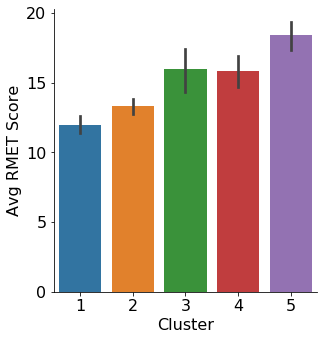

In [66]:
g = sns.catplot(x="clust", y="rmet", kind='bar', data=lwr_allDF)
g.set(xlabel='Cluster', ylabel='Avg RMET Score')
plt.tight_layout()
#plt.savefig('figs/fig3a_medsplt_lwr50_rmet_clust_barplot.png')

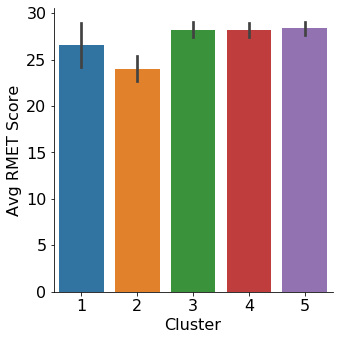

In [67]:
g = sns.catplot(x="clust", y="rmet", kind='bar', data=gtr_allDF)
g.set(xlabel='Cluster', ylabel='Avg RMET Score')
plt.tight_layout()
#plt.savefig('figs/fig3b_medsplt_gtr50_rmet_clust_barplot.png')

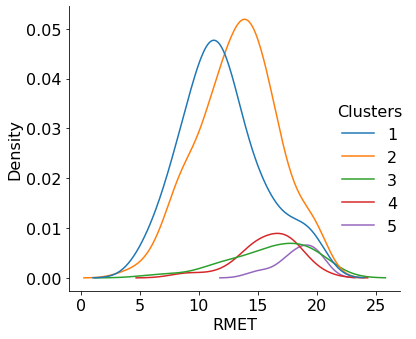

In [68]:
g = sns.displot(data=lwr_allDF, x="rmet", hue="clust", kind="kde", palette="tab10")
g._legend.set_title("Clusters")
g.set(xlabel='RMET')
plt.tight_layout()
#plt.savefig('figs/fig7a_medsplt_lwr50_rmet_clust_distplot.png')

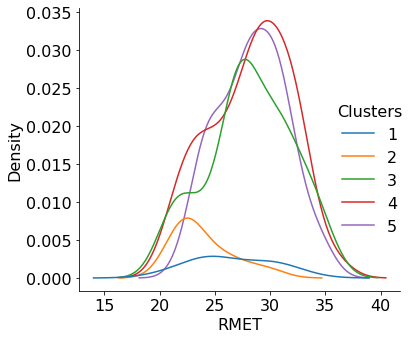

In [69]:
g = sns.displot(data=gtr_allDF, x="rmet", hue="clust", kind="kde", palette="tab10")
g._legend.set_title("Clusters")
g.set(xlabel='RMET')
plt.tight_layout()
#plt.savefig('figs/fig7b_medsplt_gtr50_rmet_clust_distplot.png')

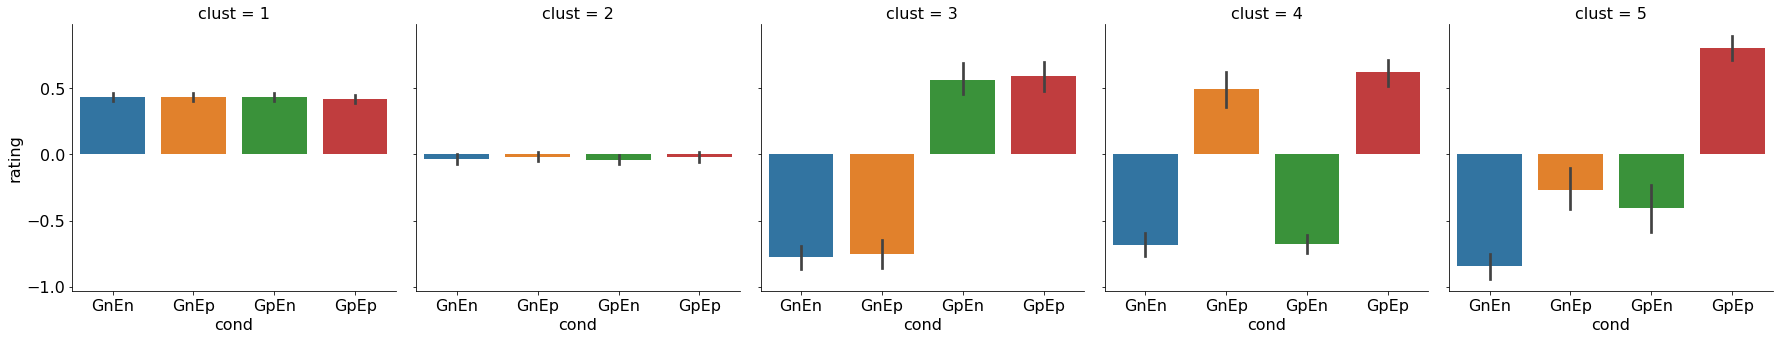

In [70]:
g = sns.catplot(x="cond", y="rating", kind='bar', col="clust", col_wrap=5, data=rmet_lwr_melt)
plt.tight_layout()
#plt.savefig('figs/fig16_medsplt_lwr50_conds_barplot.png')

In [71]:
len(rmet_gtr_melt)

1128

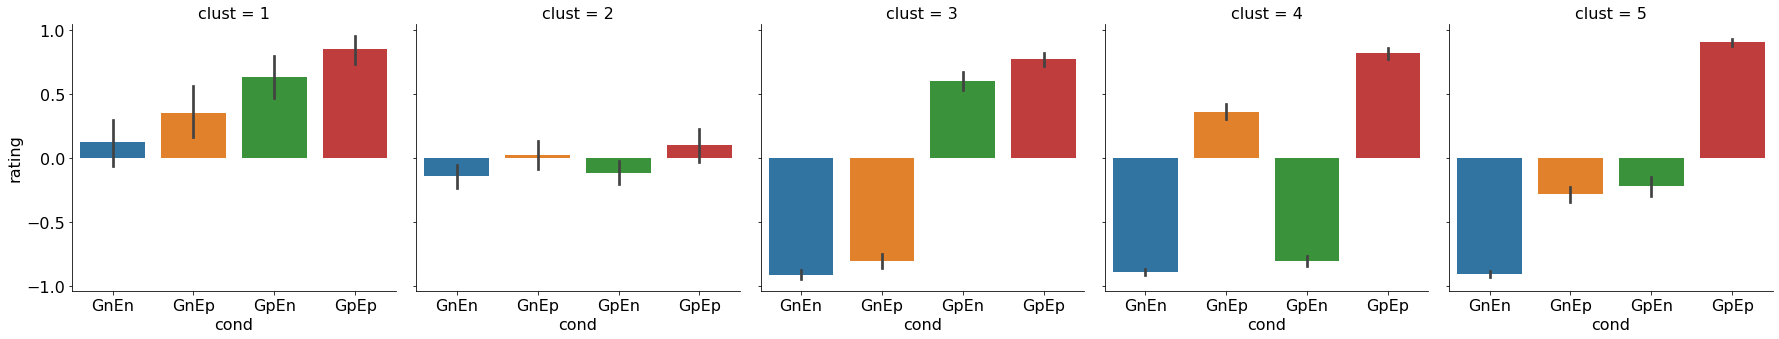

In [72]:
g = sns.catplot(x="cond", y="rating", kind='bar', col="clust", col_wrap=5, data=rmet_gtr_melt)
plt.tight_layout()
#plt.savefig('figs/fig15_medsplt_gtr50_conds_barplot.png')

In [73]:
allHT_med = statistics.median(allHT["ht"])
lwr_allHT = allHT[allHT.ht <= allHT_med]
ht_lwr = lwr_allHT.drop(columns=['rmet', 'ht'])
gtr_allHT = allHT[allHT.ht > allHT_med]
ht_gtr = lwr_allHT.drop(columns=['rmet', 'ht'])
ht_gtr_melt = pd.melt(ht_gtr,('sub','clust'),var_name='cond',value_name='rating')
ht_lwr_melt = pd.melt(ht_lwr,('sub','clust'),var_name='cond',value_name='rating')

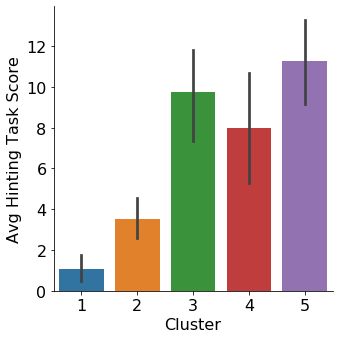

In [74]:
g = sns.catplot(x="clust", y="ht", kind='bar', data=lwr_allHT)
g.set(xlabel='Cluster', ylabel='Avg Hinting Task Score')
plt.tight_layout()
#plt.savefig('figs/fig4a_medsplt_lwr50_ht_clust_barplot.png')

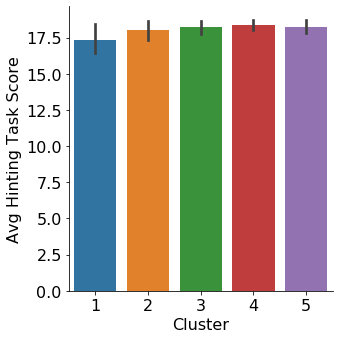

In [75]:
g = sns.catplot(x="clust", y="ht", kind='bar', data=gtr_allHT)
g.set(xlabel='Cluster', ylabel='Avg Hinting Task Score')
plt.tight_layout()
#plt.savefig('figs/fig4b_medsplt_gtr50_ht_clust_barplot.png')

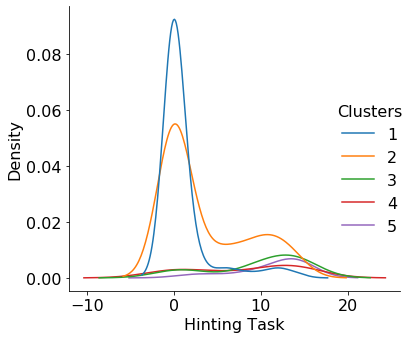

In [76]:
g = sns.displot(data=lwr_allHT, x="ht", hue="clust", kind="kde", palette="tab10")
g._legend.set_title("Clusters")
g.set(xlabel='Hinting Task')
plt.tight_layout()
#plt.savefig('figs/fig6a_medsplt_lwr50_ht_clust_distplot.png')

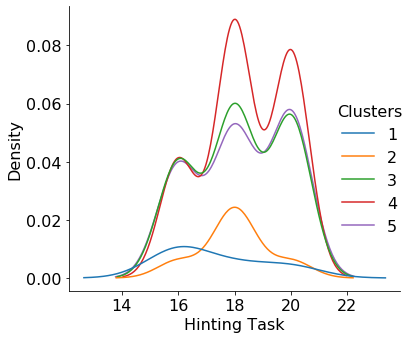

In [77]:
g = sns.displot(data=gtr_allHT, x="ht", hue="clust", kind="kde", palette="tab10")
g._legend.set_title("Clusters")
g.set(xlabel='Hinting Task')
plt.tight_layout()
#plt.savefig('figs/fig6b_medsplt_gtr50_ht_clust_distplot.png')

In [78]:
# Means by cluster
print("Lower Split - RMET & HT")
l_rclust1 = lwr_allDF[lwr_allDF["clust"] == 1]
l_hclust1 = lwr_allHT[lwr_allHT["clust"] == 1]
l_rc1 = l_rclust1["rmet"]
l_hc1 = l_hclust1["ht"]
l_c1_rmean = round(l_rc1.mean(),2)
l_c1_hmean = round(l_hc1.mean(),2)
print("clust1: rmet mean = " + str(l_c1_rmean) + ", ht mean = " + str(l_c1_hmean))
l_rc1_num = len(l_rc1)
l_hc1_num = len(l_hc1)
print("Number of c1-rmet subs: " + str(l_rc1_num))
print("Number of c1-ht subs: " + str(l_hc1_num))
###
l_rclust2 = lwr_allDF[lwr_allDF["clust"] == 2]
l_hclust2 = lwr_allHT[lwr_allHT["clust"] == 2]
l_rc2 = l_rclust2["rmet"]
l_hc2 = l_hclust2["ht"]
l_c2_rmean = round(l_rc2.mean(),2)
l_c2_hmean = round(l_hc2.mean(),2)
print("clust2: rmet mean = " + str(l_c2_rmean) + ", ht mean = " + str(l_c2_hmean))
l_rc2_num = len(l_rc2)
l_hc2_num = len(l_hc2)
print("Number of c2-rmet subs: " + str(l_rc2_num))
print("Number of c2-ht subs: " + str(l_hc2_num))
###
l_rclust3 = lwr_allDF[lwr_allDF["clust"] == 3]
l_hclust3 = lwr_allHT[lwr_allHT["clust"] == 3]
l_rc3 = l_rclust3["rmet"]
l_hc3 = l_hclust3["ht"]
l_c3_rmean = round(l_rc3.mean(),2)
l_c3_hmean = round(l_hc3.mean(),2)
print("clust3: rmet mean = " + str(l_c3_rmean) + ", ht mean = " + str(l_c3_hmean))
l_rc3_num = len(l_rc3)
l_hc3_num = len(l_hc3)
print("Number of c3-rmet subs: " + str(l_rc3_num))
print("Number of c3-ht subs: " + str(l_hc3_num))
###
l_rclust4 = lwr_allDF[lwr_allDF["clust"] == 4]
l_hclust4 = lwr_allHT[lwr_allHT["clust"] == 4]
l_rc4 = l_rclust4["rmet"]
l_hc4 = l_hclust4["ht"]
l_c4_rmean = round(l_rc4.mean(),2)
l_c4_hmean = round(l_hc4.mean(),2)
print("clust4: rmet mean = " + str(l_c4_rmean) + ", ht mean = " + str(l_c4_hmean))
l_rc4_num = len(l_rc4)
l_hc4_num = len(l_hc4)
print("Number of c4-rmet subs: " + str(l_rc4_num))
print("Number of c4-ht subs: " + str(l_hc4_num))
###
l_rclust5 = lwr_allDF[lwr_allDF["clust"] == 5]
l_hclust5 = lwr_allHT[lwr_allHT["clust"] == 5]
l_rc5 = l_rclust5["rmet"]
l_hc5 = l_hclust5["ht"]
l_c5_rmean = round(l_rc5.mean(),2)
l_c5_hmean = round(l_hc5.mean(),2)
print("clust5: rmet mean = " + str(l_c5_rmean) + ", ht mean = " + str(l_c5_hmean))
l_rc5_num = len(l_rc5)
l_hc5_num = len(l_hc5)
print("Number of c5-rmet subs: " + str(l_rc5_num))
print("Number of c5-ht subs: " + str(l_hc5_num))
###
print("Total # of rmet subs: " + str(sum([l_rc1_num,l_rc2_num,l_rc3_num,l_rc4_num,l_rc5_num])))
print("Total # of ht subs: " + str(sum([l_hc1_num,l_hc2_num,l_hc3_num,l_hc4_num,l_hc5_num])))

Lower Split - RMET & HT
clust1: rmet mean = 11.98, ht mean = 1.08
Number of c1-rmet subs: 122
Number of c1-ht subs: 78
clust2: rmet mean = 13.33, ht mean = 3.52
Number of c2-rmet subs: 137
Number of c2-ht subs: 99
clust3: rmet mean = 16.0, ht mean = 9.73
Number of c3-rmet subs: 20
Number of c3-ht subs: 22
clust4: rmet mean = 15.83, ht mean = 8.0
Number of c4-rmet subs: 18
Number of c4-ht subs: 17
clust5: rmet mean = 18.44, ht mean = 11.29
Number of c5-rmet subs: 9
Number of c5-ht subs: 14
Total # of rmet subs: 306
Total # of ht subs: 230


In [79]:
# Means by cluster
print("Greater Split - RMET & HT")
g_rclust1 = gtr_allDF[gtr_allDF["clust"] == 1]
g_hclust1 = gtr_allHT[gtr_allHT["clust"] == 1]
g_rc1 = g_rclust1["rmet"]
g_hc1 = g_hclust1["ht"]
g_c1_rmean = round(g_rc1.mean(),2)
g_c1_hmean = round(g_hc1.mean(),2)
print("clust1: rmet mean = " + str(g_c1_rmean) + ", ht mean = " + str(g_c1_hmean))
g_rc1_num = len(g_rc1)
g_hc1_num = len(g_hc1)
print("Number of c1-rmet subs: " + str(g_rc1_num))
print("Number of c1-ht subs: " + str(g_hc1_num))
###
g_rclust2 = gtr_allDF[gtr_allDF["clust"] == 2]
g_hclust2 = gtr_allHT[gtr_allHT["clust"] == 2]
g_rc2 = g_rclust2["rmet"]
g_hc2 = g_hclust2["ht"]
g_c2_rmean = round(g_rc2.mean(),2)
g_c2_hmean = round(g_hc2.mean(),2)
print("clust2: rmet mean = " + str(g_c2_rmean) + ", ht mean = " + str(g_c2_hmean))
g_rc2_num = len(g_rc2)
g_hc2_num = len(g_hc2)
print("Number of c2-rmet subs: " + str(g_rc2_num))
print("Number of c2-ht subs: " + str(g_hc2_num))
###
g_rclust3 = gtr_allDF[gtr_allDF["clust"] == 3]
g_hclust3 = gtr_allHT[gtr_allHT["clust"] == 3]
g_rc3 = g_rclust3["rmet"]
g_hc3 = g_hclust3["ht"]
g_c3_rmean = round(g_rc3.mean(),2)
g_c3_hmean = round(g_hc3.mean(),2)
print("clust3: rmet mean = " + str(g_c3_rmean) + ", ht mean = " + str(g_c3_hmean))
g_rc3_num = len(g_rc3)
g_hc3_num = len(g_hc3)
print("Number of c3-rmet subs: " + str(g_rc3_num))
print("Number of c3-ht subs: " + str(g_hc3_num))
###
g_rclust4 = gtr_allDF[gtr_allDF["clust"] == 4]
g_hclust4 = gtr_allHT[gtr_allHT["clust"] == 4]
g_rc4 = g_rclust4["rmet"]
g_hc4 = g_hclust4["ht"]
g_c4_rmean = round(g_rc4.mean(),2)
g_c4_hmean = round(g_hc4.mean(),2)
print("clust4: rmet mean = " + str(g_c4_rmean) + ", ht mean = " + str(g_c4_hmean))
g_rc4_num = len(g_rc4)
g_hc4_num = len(g_hc4)
print("Number of c4-rmet subs: " + str(g_rc4_num))
print("Number of c4-ht subs: " + str(g_hc4_num))
###
g_rclust5 = gtr_allDF[gtr_allDF["clust"] == 5]
g_hclust5 = gtr_allHT[gtr_allHT["clust"] == 5]
g_rc5 = g_rclust5["rmet"]
g_hc5 = g_hclust5["ht"]
g_c5_rmean = round(g_rc5.mean(),2)
g_c5_hmean = round(g_hc5.mean(),2)
print("clust5: rmet mean = " + str(g_c5_rmean) + ", ht mean = " + str(g_c5_hmean))
g_rc5_num = len(g_rc5)
g_hc5_num = len(g_hc5)
print("Number of c5-rmet subs: " + str(g_rc5_num))
print("Number of c5-ht subs: " + str(g_hc5_num))
###
print("Total # of rmet subs: " + str(sum([g_rc1_num,g_rc2_num,g_rc3_num,g_rc4_num,g_rc5_num])))
print("Total # of ht subs: " + str(sum([g_hc1_num,g_hc2_num,g_hc3_num,g_hc4_num,g_hc5_num])))

Greater Split - RMET & HT
clust1: rmet mean = 26.56, ht mean = 17.33
Number of c1-rmet subs: 9
Number of c1-ht subs: 9
clust2: rmet mean = 23.93, ht mean = 18.0
Number of c2-rmet subs: 14
Number of c2-ht subs: 12
clust3: rmet mean = 28.15, ht mean = 18.2
Number of c3-rmet subs: 80
Number of c3-ht subs: 50
clust4: rmet mean = 28.21, ht mean = 18.36
Number of c4-rmet subs: 97
Number of c4-ht subs: 61
clust5: rmet mean = 28.37, ht mean = 18.24
Number of c5-rmet subs: 82
Number of c5-ht subs: 49
Total # of rmet subs: 282
Total # of ht subs: 181


In [80]:
rmet_med = statistics.median(incallDF["rmet"])
lt_rmet = incallDF[incallDF.rmet <= rmet_med]
gt_rmet = incallDF[incallDF.rmet > rmet_med]

In [81]:
model = ols(formula='rmet ~ intDiff + gazeDiff + exprDiff', data=lt_rmet).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rmet   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     12.35
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           1.21e-07
Time:                        14:47:34   Log-Likelihood:                -812.63
No. Observations:                 306   AIC:                             1633.
Df Residuals:                     302   BIC:                             1648.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    206.6862    111.109      1.860      0.0

In [82]:
X = gt_rmet[["intDiff"]+["gazeDiff"]+["exprDiff"]]
print(X)
y = gt_rmet[["rmet"]]
print(y)

     intDiff  gazeDiff  exprDiff
1       0.10      1.45      2.76
2       0.20      2.53      1.88
4       1.05      0.22      5.88
7       0.52      3.18      1.86
9       0.10      1.37      2.84
10      0.54      3.97      1.11
11      1.27      0.60      5.94
12      1.18      0.30      6.05
14      1.39      0.53      6.25
16      1.87      0.00      7.74
18      0.90      0.80      5.01
19      0.68      3.60      1.76
20      1.03      5.38      0.67
22      0.62      0.71      4.54
25      0.24      2.54      1.95
26      0.01      1.84      2.18
27      1.00      1.03      4.97
28      1.19      6.19      0.19
29      1.06      3.98      2.14
30      0.19      2.90      1.47
32      0.38      3.31      1.46
33      1.73      7.42      0.03
39      1.52      6.96      0.07
40      0.89      0.62      5.16
41      1.92      5.17      2.67
43      1.40      0.47      6.34
45      0.14      1.29      2.99
46      1.52      0.48      6.55
48      0.19      1.75      2.62
49      1.

In [83]:
clf = Ridge(alpha=1.0)
clf.fit(X, y)
Ridge()
clf.score(X,y)
clf.coef_

array([[-0.63062311, -0.28065315, -0.19655885]])

In [84]:
model = ols(formula='rmet ~ intDiff + gazeDiff + exprDiff', data=gt_rmet).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rmet   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.731
Date:                Tue, 24 Aug 2021   Prob (F-statistic):            0.00309
Time:                        14:47:34   Log-Likelihood:                -756.83
No. Observations:                 282   AIC:                             1522.
Df Residuals:                     278   BIC:                             1536.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -206.3890    123.977     -1.665      0.0

In [85]:
model1 = ols(formula="gt_rmet[\"rmet\"] ~ gt_rmet[\"intDiff\"] + gt_rmet[\"gazeDiff\"] + gt_rmet[\"exprDiff\"]", data=gt_rmet)
model2 = model1.fit_regularized(L1_wt=0)
print(model2)

In [86]:
gt_rmet

,sub,clust,GnEn,GnEp,GpEn,GpEp,rmet,ht,intDiff,gazeDiff,exprDiff
1,s002,5,-0.933333,-0.310345,0.016667,1.000000,31,NaN,0.10,1.45,2.76
2,s003,5,-0.964286,-0.224138,-0.385965,0.933333,29,NaN,0.20,2.53,1.88
4,s005,3,-0.933333,-0.736842,0.677966,0.800000,33,NaN,1.05,0.22,5.88
7,s009,5,-0.762712,-0.203390,-0.533333,0.633333,23,NaN,0.52,3.18,1.86
9,s011,5,-0.833333,-0.200000,0.166667,0.916667,30,NaN,0.10,1.37,2.84
10,s013,4,-0.966667,-0.016667,-0.733333,1.000000,31,NaN,0.54,3.97,1.11
11,s014,3,-0.600000,-0.333333,1.000000,0.983333,27,NaN,1.27,0.60,5.94
12,s015,3,-0.854545,-0.800000,0.637931,0.672414,28,NaN,1.18,0.30,6.05
14,s018,3,-0.949153,-0.913793,0.516667,0.466667,21,NaN,1.39,0.53,6.25
16,s020,3,-1.000000,-1.000000,0.933333,1.000000,23,NaN,1.87,0.00,7.74


(-0.31646854929578677, 1.5190365716329347e-08)

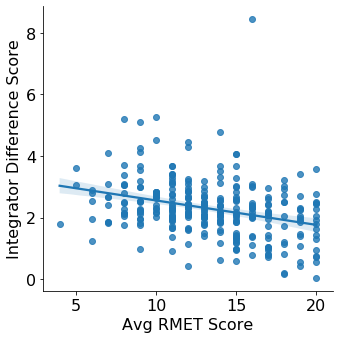

In [87]:
g = sns.lmplot(data=lt_rmet, x="rmet", y="intDiff")
stats.pearsonr(lt_rmet["rmet"],lt_rmet["intDiff"])
g.set(xlabel='Avg RMET Score', ylabel='Integrator Difference Score')
plt.tight_layout()
plt.savefig('figs/fig17a_medsplt_lwr50_rmet_int_scatterplot.pdf')
stats.pearsonr(lt_rmet["rmet"],lt_rmet["intDiff"])

In [88]:
# Fit the model
model = ols("lt_rmet[\"rmet\"] ~ lt_rmet[\"intDiff\"]", lt_rmet).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        lt_rmet["rmet"]   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     33.83
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           1.52e-08
Time:                        14:47:35   Log-Likelihood:                -814.19
No. Observations:                 306   AIC:                             1632.
Df Residuals:                     304   BIC:                             1640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             16.1583      0

(-0.18377455043673258, 0.0019428870918749008)

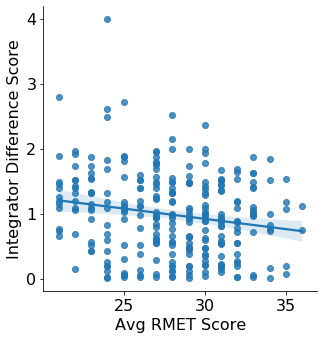

In [89]:
g = sns.lmplot(data=gt_rmet, x="rmet", y="intDiff")
stats.pearsonr(gt_rmet["rmet"],gt_rmet["intDiff"])
g.set(xlabel='Avg RMET Score', ylabel='Integrator Difference Score')
plt.tight_layout()
plt.savefig('figs/fig17b_medsplt_gtr50_rmet_int_scatterplot.pdf')
stats.pearsonr(gt_rmet["rmet"],gt_rmet["intDiff"])

In [90]:
# Fit the model
model = ols("gt_rmet[\"rmet\"] ~ gt_rmet[\"intDiff\"]", gt_rmet).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        gt_rmet["rmet"]   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     9.787
Date:                Tue, 24 Aug 2021   Prob (F-statistic):            0.00194
Time:                        14:47:36   Log-Likelihood:                -759.01
No. Observations:                 282   AIC:                             1522.
Df Residuals:                     280   BIC:                             1529.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             29.0212      0

(-0.21311013873459006, 0.0001727314214836636)

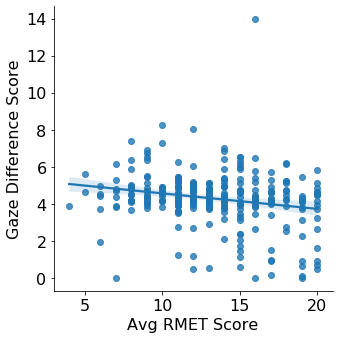

In [91]:
g = sns.lmplot(data=lt_rmet, x="rmet", y="gazeDiff")
stats.pearsonr(lt_rmet["rmet"],lt_rmet["gazeDiff"])
g.set(xlabel='Avg RMET Score', ylabel='Gaze Difference Score')
plt.tight_layout()
plt.savefig('figs/fig18a_medsplt_lwr50_rmet_gaze_scatterplot.pdf')
stats.pearsonr(lt_rmet["rmet"],lt_rmet["gazeDiff"])

In [92]:
# Fit the model
model = ols("lt_rmet[\"rmet\"] ~ lt_rmet[\"gazeDiff\"]", lt_rmet).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        lt_rmet["rmet"]   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     14.46
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           0.000173
Time:                        14:47:37   Log-Likelihood:                -823.23
No. Observations:                 306   AIC:                             1650.
Df Residuals:                     304   BIC:                             1658.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              15.5876    

(-0.07356421193862994, 0.2181226718758388)

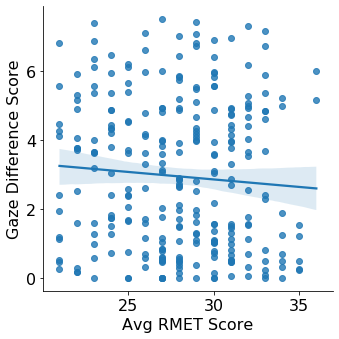

In [93]:
g = sns.lmplot(data=gt_rmet, x="rmet", y="gazeDiff")
stats.pearsonr(gt_rmet["rmet"],gt_rmet["gazeDiff"])
g.set(xlabel='Avg RMET Score', ylabel='Gaze Difference Score')
plt.tight_layout()
plt.savefig('figs/fig18b_medsplt_gtr50_rmet_gaze_scatterplot.pdf')
stats.pearsonr(gt_rmet["rmet"],gt_rmet["gazeDiff"])

In [94]:
# Fit the model
model = ols("gt_rmet[\"rmet\"] ~ gt_rmet[\"gazeDiff\"]", gt_rmet).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        gt_rmet["rmet"]   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.524
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.218
Time:                        14:47:38   Log-Likelihood:                -763.09
No. Observations:                 282   AIC:                             1530.
Df Residuals:                     280   BIC:                             1537.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              28.3375    

(-0.21494466182317917, 0.0001512619533851401)

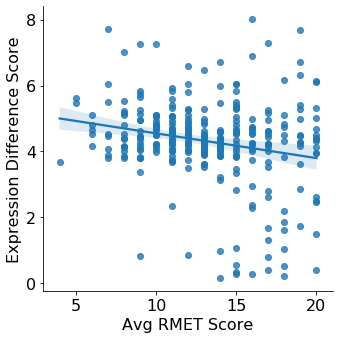

In [95]:
g = sns.lmplot(data=lt_rmet, x="rmet", y="exprDiff")
stats.pearsonr(lt_rmet["rmet"],lt_rmet["exprDiff"])
g.set(xlabel='Avg RMET Score', ylabel='Expression Difference Score')
plt.tight_layout()
plt.savefig('figs/fig19a_medsplt_lwr50_rmet_expr_scatterplot.pdf')
stats.pearsonr(lt_rmet["rmet"],lt_rmet["exprDiff"])

In [96]:
# Fit the model
model = ols("lt_rmet[\"rmet\"] ~ lt_rmet[\"exprDiff\"]", lt_rmet).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        lt_rmet["rmet"]   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     14.73
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           0.000151
Time:                        14:47:39   Log-Likelihood:                -823.10
No. Observations:                 306   AIC:                             1650.
Df Residuals:                     304   BIC:                             1658.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              15.9056    

(-0.030120695307938435, 0.6144861745456743)

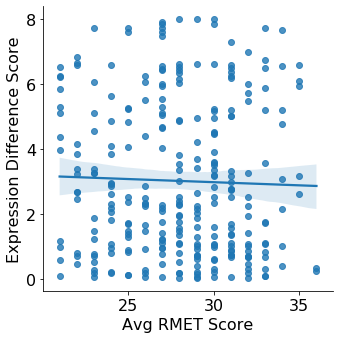

In [97]:
g = sns.lmplot(data=gt_rmet, x="rmet", y="exprDiff")
stats.pearsonr(gt_rmet["rmet"],gt_rmet["exprDiff"])
g.set(xlabel='Avg RMET Score', ylabel='Expression Difference Score')
plt.tight_layout()
plt.savefig('figs/fig19b_medsplt_gtr50_rmet_expr_scatterplot.pdf')
stats.pearsonr(gt_rmet["rmet"],gt_rmet["exprDiff"])

In [98]:
# Fit the model
model = ols("gt_rmet[\"rmet\"] ~ gt_rmet[\"exprDiff\"]", gt_rmet).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        gt_rmet["rmet"]   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2543
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.614
Time:                        14:47:40   Log-Likelihood:                -763.72
No. Observations:                 282   AIC:                             1531.
Df Residuals:                     280   BIC:                             1539.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              28.1128    

In [99]:
ht_med = statistics.median(incallHT["ht"])
lt_ht = incallHT[incallHT.ht <= ht_med]
gt_ht = incallHT[incallHT.ht > ht_med]

In [100]:
print(rmet_med)
print(ht_med)

20.0
14.0


(-0.5612542169087733, 1.7281951802614905e-20)

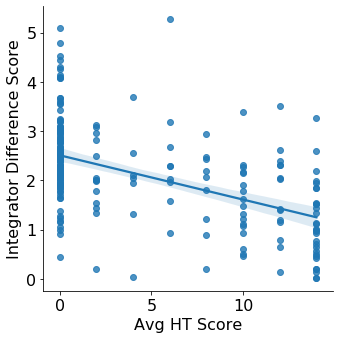

In [101]:
g = sns.lmplot(data=lt_ht, x="ht", y="intDiff")
stats.pearsonr(lt_ht["ht"],lt_ht["intDiff"])
g.set(xlabel='Avg HT Score', ylabel='Integrator Difference Score')
plt.tight_layout()
plt.savefig('figs/fig20a_medsplt_lwr50_ht_int_scatterplot.pdf')
stats.pearsonr(lt_ht["rmet"],lt_ht["intDiff"])

In [102]:
# Fit the model
model = ols("lt_ht[\"rmet\"] ~ lt_ht[\"intDiff\"]", lt_ht).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          lt_ht["rmet"]   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     104.8
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           1.73e-20
Time:                        14:47:41   Log-Likelihood:                -701.86
No. Observations:                 230   AIC:                             1408.
Df Residuals:                     228   BIC:                             1415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           23.1264      0.824  

(-0.26984281659254855, 0.0002391610236911016)

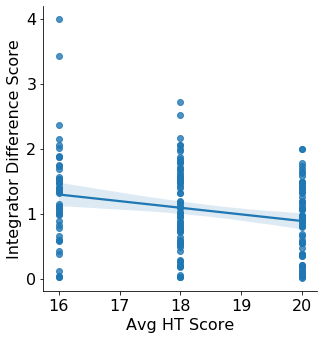

In [103]:
g = sns.lmplot(data=gt_ht, x="ht", y="intDiff")
stats.pearsonr(gt_ht["ht"],gt_ht["intDiff"])
g.set(xlabel='Avg HT Score', ylabel='Integrator Difference Score')
plt.tight_layout()
plt.savefig('figs/fig20b_medsplt_gtr50_ht_int_scatterplot.pdf')
stats.pearsonr(gt_ht["rmet"],gt_ht["intDiff"])

In [104]:
# Fit the model
model = ols("gt_ht[\"rmet\"] ~ gt_ht[\"intDiff\"]", gt_ht).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          gt_ht["rmet"]   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     14.06
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           0.000239
Time:                        14:47:41   Log-Likelihood:                -532.08
No. Observations:                 181   AIC:                             1068.
Df Residuals:                     179   BIC:                             1075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           29.5906      0.646  

(-0.40252287659724073, 2.2740124806291273e-10)

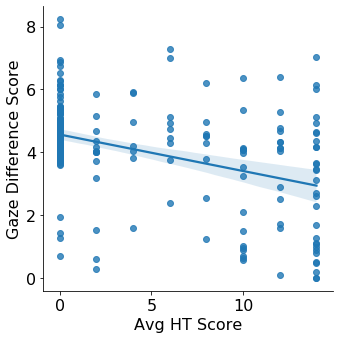

In [105]:
g = sns.lmplot(data=lt_ht, x="ht", y="gazeDiff")
stats.pearsonr(lt_ht["ht"],lt_ht["gazeDiff"])
g.set(xlabel='Avg HT Score', ylabel='Gaze Difference Score')
plt.tight_layout()
plt.savefig('figs/fig21a_medsplt_lwr50_ht_gaze_scatterplot.pdf')
stats.pearsonr(lt_ht["rmet"],lt_ht["gazeDiff"])

In [106]:
# Fit the model
model = ols("lt_ht[\"rmet\"] ~ lt_ht[\"gazeDiff\"]", lt_ht).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          lt_ht["rmet"]   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     44.08
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           2.27e-10
Time:                        14:47:42   Log-Likelihood:                -725.04
No. Observations:                 230   AIC:                             1454.
Df Residuals:                     228   BIC:                             1461.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.0126      1.06

(-0.05704686638587218, 0.4455878644574538)

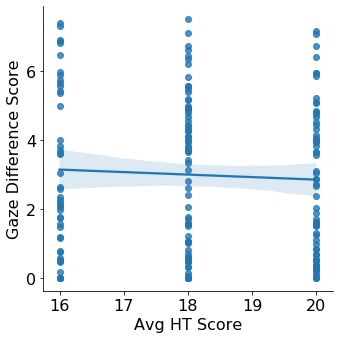

In [107]:
g = sns.lmplot(data=gt_ht, x="ht", y="gazeDiff")
stats.pearsonr(gt_ht["ht"],gt_ht["gazeDiff"])
g.set(xlabel='Avg HT Score', ylabel='Gaze Difference Score')
plt.tight_layout()
plt.savefig('figs/fig21b_medsplt_gtr50_ht_gaze_scatterplot.pdf')
stats.pearsonr(gt_ht["rmet"],gt_ht["gazeDiff"])

In [108]:
# Fit the model
model = ols("gt_ht[\"rmet\"] ~ gt_ht[\"gazeDiff\"]", gt_ht).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          gt_ht["rmet"]   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5844
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.446
Time:                        14:47:43   Log-Likelihood:                -538.63
No. Observations:                 181   AIC:                             1081.
Df Residuals:                     179   BIC:                             1088.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            27.9050      0.59

(-0.3327686564609048, 2.376174740649993e-07)

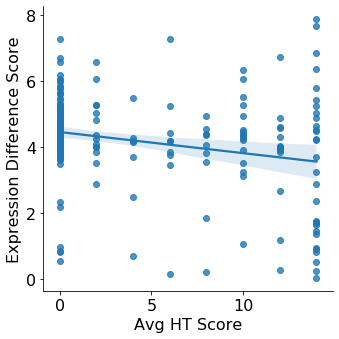

In [109]:
g = sns.lmplot(data=lt_ht, x="ht", y="exprDiff")
stats.pearsonr(lt_ht["ht"],lt_ht["exprDiff"])
g.set(xlabel='Avg HT Score', ylabel='Expression Difference Score')
plt.tight_layout()
plt.savefig('figs/fig22a_medsplt_lwr50_ht_expr_scatterplot.pdf')
stats.pearsonr(lt_ht["rmet"],lt_ht["exprDiff"])

In [110]:
# Fit the model
model = ols("lt_ht[\"rmet\"] ~ lt_ht[\"exprDiff\"]", lt_ht).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          lt_ht["rmet"]   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     28.39
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           2.38e-07
Time:                        14:47:44   Log-Likelihood:                -731.87
No. Observations:                 230   AIC:                             1468.
Df Residuals:                     228   BIC:                             1475.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            21.6448      1.22

(-0.0964766312351406, 0.19636273972275214)

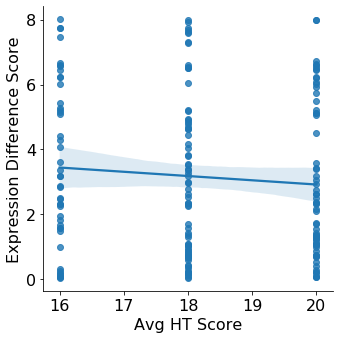

In [111]:
g = sns.lmplot(data=gt_ht, x="ht", y="exprDiff")
stats.pearsonr(gt_ht["ht"],gt_ht["exprDiff"])
g.set(xlabel='Avg HT Score', ylabel='Expression Difference Score')
plt.tight_layout()
plt.savefig('figs/fig22b_medsplt_gtr50_ht_expr_scatterplot.pdf')
stats.pearsonr(gt_ht["rmet"],gt_ht["exprDiff"])

In [112]:
# Fit the model
model = ols("gt_ht[\"rmet\"] ~ gt_ht[\"exprDiff\"]", gt_ht).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          gt_ht["rmet"]   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.682
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.196
Time:                        14:47:45   Log-Likelihood:                -538.08
No. Observations:                 181   AIC:                             1080.
Df Residuals:                     179   BIC:                             1087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            28.1331      0.58

## New Splits

In [113]:
incallDF[incallDF.exprDiff > 8]

,sub,clust,GnEn,GnEp,GpEn,GpEp,rmet,ht,intDiff,gazeDiff,exprDiff
531,s734,3,-0.982759,-1.0,1.0,0.923077,16,16.0,2.01,0.01,8.01


In [114]:
stratBar = allDF[allDF.clust >= 3]
stratCorr = incallDF[incallDF.clust >= 3]

In [115]:
stratCorr.shape

(306, 11)

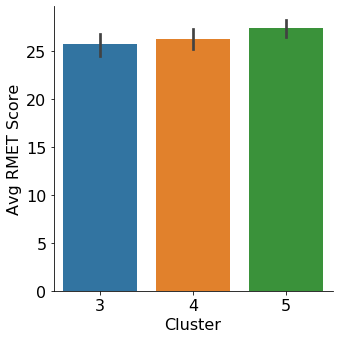

In [116]:
g = sns.catplot(x="clust", y="rmet", kind='bar', data=stratBar)
g.set(xlabel='Cluster', ylabel='Avg RMET Score')
plt.tight_layout()

(-0.1598099541311785, 0.005076761633848256)

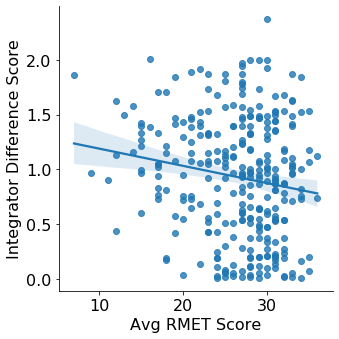

In [117]:
g = sns.lmplot(data=stratCorr, x="rmet", y="intDiff")
stats.pearsonr(stratCorr["rmet"],stratCorr["intDiff"])
g.set(xlabel='Avg RMET Score', ylabel='Integrator Difference Score')
plt.tight_layout()
plt.savefig('figs/newSplit_rmet_int_scatter.png')
stats.pearsonr(stratCorr["rmet"],stratCorr["intDiff"])

In [118]:
# Fit the model
model = ols("stratCorr[\"rmet\"] ~ stratCorr[\"intDiff\"]", stratCorr).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      stratCorr["rmet"]   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.967
Date:                Tue, 24 Aug 2021   Prob (F-statistic):            0.00508
Time:                        14:47:47   Log-Likelihood:                -951.79
No. Observations:                 306   AIC:                             1908.
Df Residuals:                     304   BIC:                             1915.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               27.9337 

(-0.031031435688788724, 0.5886888326017196)

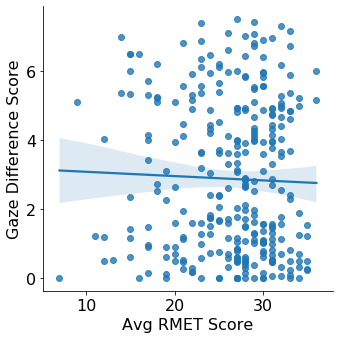

In [119]:
g = sns.lmplot(data=stratCorr, x="rmet", y="gazeDiff")
stats.pearsonr(stratCorr["rmet"],stratCorr["gazeDiff"])
g.set(xlabel='Avg RMET Score', ylabel='Gaze Difference Score')
plt.tight_layout()
plt.savefig('figs/newSplit_rmet_gaze_scatter.png')
stats.pearsonr(stratCorr["rmet"],stratCorr["gazeDiff"])

In [120]:
# Fit the model
model = ols("stratCorr[\"rmet\"] ~ stratCorr[\"gazeDiff\"]", stratCorr).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      stratCorr["rmet"]   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2930
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.589
Time:                        14:47:48   Log-Likelihood:                -955.60
No. Observations:                 306   AIC:                             1915.
Df Residuals:                     304   BIC:                             1923.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                26.64

(-0.042900801230684404, 0.4546227453624013)

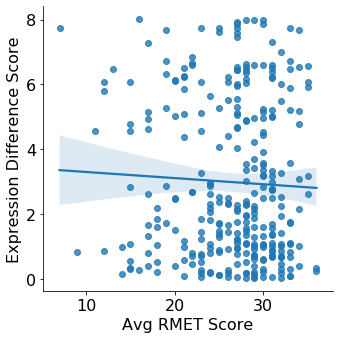

In [121]:
g = sns.lmplot(data=stratCorr, x="rmet", y="exprDiff")
stats.pearsonr(stratCorr["rmet"],stratCorr["exprDiff"])
g.set(xlabel='Avg RMET Score', ylabel='Expression Difference Score')
plt.tight_layout()
plt.savefig('figs/newSplit_rmet_expr_scatter.png')
stats.pearsonr(stratCorr["rmet"],stratCorr["exprDiff"])

In [122]:
# Fit the model
model = ols("stratCorr[\"rmet\"] ~ stratCorr[\"exprDiff\"]", stratCorr).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      stratCorr["rmet"]   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5605
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.455
Time:                        14:47:49   Log-Likelihood:                -955.47
No. Observations:                 306   AIC:                             1915.
Df Residuals:                     304   BIC:                             1922.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                26.71

In [123]:
stratBarHT = allHT[allHT.clust >= 3]
stratCorrHT = incallHT[incallHT.clust >= 3]

In [124]:
stratCorrHT.shape

(213, 11)

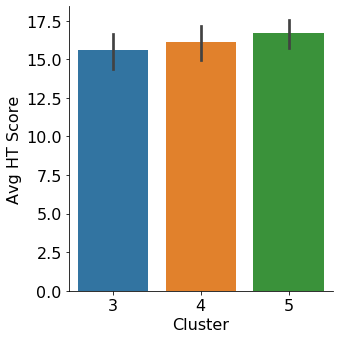

In [125]:
g = sns.catplot(x="clust", y="ht", kind='bar', data=stratBarHT)
g.set(xlabel='Cluster', ylabel='Avg HT Score')
plt.tight_layout()

(-0.05737863471636986, 0.40474740987579344)

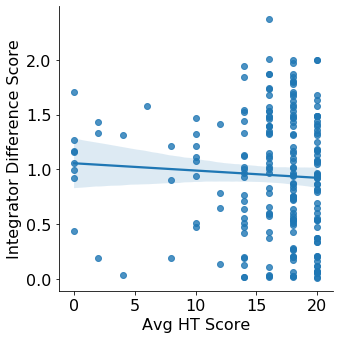

In [126]:
g = sns.lmplot(data=stratCorrHT, x="ht", y="intDiff")
stats.pearsonr(stratCorrHT["ht"],stratCorrHT["intDiff"])
g.set(xlabel='Avg HT Score', ylabel='Integrator Difference Score')
plt.tight_layout()
plt.savefig('figs/newSplit_ht_int_scatter.png')
stats.pearsonr(stratCorrHT["ht"],stratCorrHT["intDiff"])

In [127]:
# Fit the model
model = ols("stratCorrHT[\"ht\"] ~ stratCorrHT[\"intDiff\"]", stratCorrHT).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      stratCorrHT["ht"]   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6970
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.405
Time:                        14:47:50   Log-Likelihood:                -635.17
No. Observations:                 213   AIC:                             1274.
Df Residuals:                     211   BIC:                             1281.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 16

(-0.0038315560177245543, 0.9556677414321061)

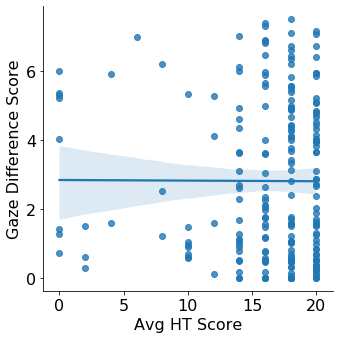

In [128]:
g = sns.lmplot(data=stratCorrHT, x="ht", y="gazeDiff")
stats.pearsonr(stratCorrHT["ht"],stratCorrHT["gazeDiff"])
g.set(xlabel='Avg HT Score', ylabel='Gaze Difference Score')
plt.tight_layout()
plt.savefig('figs/newSplit_ht_gaze_scatter.png')
stats.pearsonr(stratCorrHT["ht"],stratCorrHT["gazeDiff"])

In [129]:
# Fit the model
model = ols("stratCorrHT[\"ht\"] ~ stratCorrHT[\"gazeDiff\"]", stratCorrHT).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      stratCorrHT["ht"]   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                  0.003098
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.956
Time:                        14:47:51   Log-Likelihood:                -635.51
No. Observations:                 213   AIC:                             1275.
Df Residuals:                     211   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

(-0.022479238770503618, 0.7442848585541294)

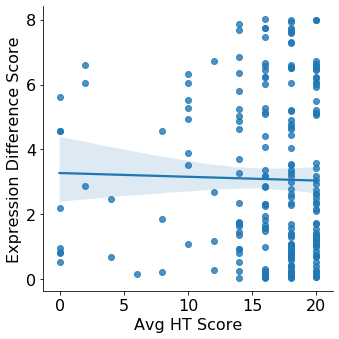

In [130]:
g = sns.lmplot(data=stratCorrHT, x="ht", y="exprDiff")
stats.pearsonr(stratCorrHT["ht"],stratCorrHT["exprDiff"])
g.set(xlabel='Avg HT Score', ylabel='Expression Difference Score')
plt.tight_layout()
plt.savefig('figs/newSplit_ht_expr_scatter.png')
stats.pearsonr(stratCorrHT["ht"],stratCorrHT["exprDiff"])

In [131]:
# Fit the model
model = ols("stratCorrHT[\"ht\"] ~ stratCorrHT[\"exprDiff\"]", stratCorrHT).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      stratCorrHT["ht"]   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1067
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.744
Time:                        14:47:52   Log-Likelihood:                -635.46
No. Observations:                 213   AIC:                             1275.
Df Residuals:                     211   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Strategy vs ambiguous

In [132]:
# Copy dictionary
rMeansDict = rmeansdict.copy()

# Pull out two lowest clusters
key_list = list(rMeansDict.keys()) 
val_list = list(rMeansDict.values())
abVal = min(val_list)
ab = key_list[val_list.index(abVal)]
val_list.remove(abVal)
key_list.remove(ab)
flatVal = min(val_list)
flat = key_list[val_list.index(flatVal)]

# Ambiguous clusters
ambig = [int(ab),int(flat)]
print(ambig)

[1, 2]


In [133]:
# RMET
stratDF = incallDF[~incallDF.clust.isin(ambig)]
nostratDF = incallDF[incallDF.clust.isin(ambig)]

In [134]:
rStrat = stratDF["rmet"]
rNostrat = nostratDF["rmet"]

(-0.1598099541311785, 0.005076761633848256)

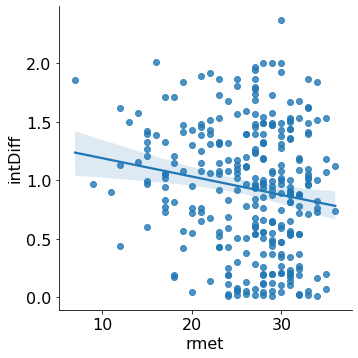

In [135]:
sns.lmplot(data=stratDF, x="rmet", y="intDiff")
stats.pearsonr(stratDF["rmet"],stratDF["intDiff"])

(-0.24399110988447187, 3.444762661389861e-05)

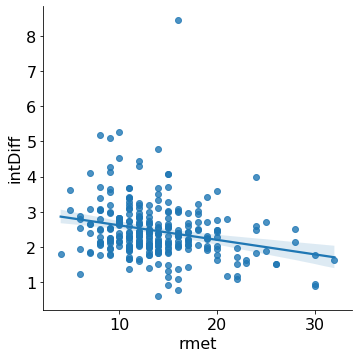

In [136]:
sns.lmplot(data=nostratDF, x="rmet", y="intDiff")
stats.pearsonr(nostratDF["rmet"],nostratDF["intDiff"])

In [137]:
# HT
stratHT = incallHT[~incallHT.clust.isin(ambig)]
nostratHT = incallHT[incallHT.clust.isin(ambig)]

In [138]:
hStrat = stratHT["ht"]
hNostrat = nostratHT["ht"]

(-0.05737863471636986, 0.40474740987579344)

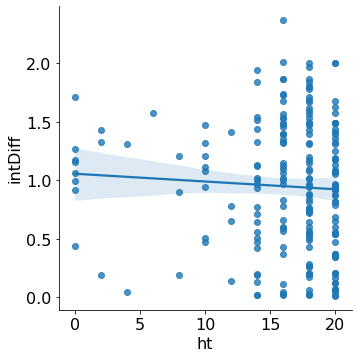

In [139]:
sns.lmplot(data=stratHT, x="ht", y="intDiff")
stats.pearsonr(stratHT["ht"],stratHT["intDiff"])

(-0.3305024726034805, 1.9800136081951195e-06)

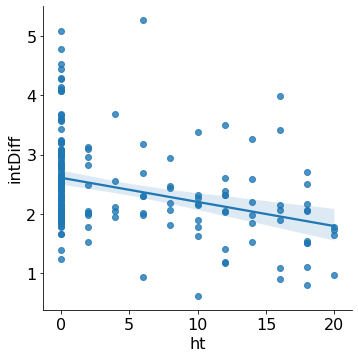

In [140]:
sns.lmplot(data=nostratHT, x="ht", y="intDiff")
stats.pearsonr(nostratHT["ht"],nostratHT["intDiff"])

## Z-tests

In [141]:
# RMET Analyses

# Flat vs Aware Biased
r_ztest1, r_pval1 = stests.ztest(rc1, x2=rc2, value=0, alternative='two-sided')
print("Flat vs Aware Biased")
if r_pval1 > 0.25:
    print("1.00")
else:
    #print(r_pval1)
    print(str(round(r_pval1,3)))
    print(str(round(r_pval1,3)*4))

# Strategy vs no-strategy
r_ztest2, r_pval2 = stests.ztest(rStrat, x2=rNostrat, value=0, alternative='two-sided')
print("Strategy vs no-strategy")
if r_pval2 > 0.25:
    print("1.00")
else:
    print(r_ztest2)
    print(str(round(r_pval2,3)))
    print(str(round(r_pval2,3)*4))

# Int vs Gaze
r_ztest3, r_pval3 = stests.ztest(rc3, x2=rc5, value=0, alternative='two-sided')
print("Int vs Gaze")
if r_pval3 > 0.25:
    print("1.00")
else:
    #print(r_pval3)
    print(str(round(r_pval3,3)))
    print(str(round(r_pval3,3)*4))

# Int vs Expr
r_ztest4, r_pval4 = stests.ztest(rc4, x2=rc5, value=0, alternative='two-sided')
print("Int vs Expr")
if r_pval4 > 0.25:
    print("1.00")
else:
    #print(r_pval4)
    print(str(round(r_pval4,3)))
    print(str(round(r_pval4,3)*4))

Flat vs Aware Biased
0.02
0.08
Strategy vs no-strategy
29.720892030468864
0.0
0.0
Int vs Gaze
0.031
0.124
Int vs Expr
0.121
0.484


In [142]:
# HT Analyses

# Flat vs Aware Biased
h_ztest1, h_pval1 = stests.ztest(hc1, x2=hc2, value=0, alternative='two-sided')
print("Flat vs Aware Biased")
if h_pval1 > 0.25:
    print("1.00")
else:
    #print(h_pval1)
    print(str(round(h_pval1,3)*4))

# Strategy vs no-strategy
h_ztest2, h_pval2 = stests.ztest(hStrat, x2=hNostrat, value=0, alternative='two-sided')
print("Strategy vs no-strategy")
if h_pval2 > 0.25:
    print("1.00")
else:
    print(h_ztest2)
    print(str(round(h_pval2,3)*4))

# Int vs Gaze
h_ztest3, h_pval3 = stests.ztest(hc3, x2=hc5, value=0, alternative='two-sided')
print("Int vs Gaze")
if h_pval3 > 0.25:
    print("1.00")
else:
    #print(h_pval3)
    print(str(round(h_pval3,3)*4))

# Int vs Expr
h_ztest4, h_pval4 = stests.ztest(hc4, x2=hc5, value=0, alternative='two-sided')
print("Int vs Expr")
if h_pval4 > 0.25:
    print("1.00")
else:
    #print(h_pval4)
    print(str(round(h_pval4,3)*4))

Flat vs Aware Biased
0.032
Strategy vs no-strategy
22.040817181674615
0.0
Int vs Gaze
0.64
Int vs Expr
1.00


In [143]:
# Median Splits - Lower 50% HT

# Flat vs Aware Biased
lh_ztest1, lh_pval1 = stests.ztest(l_hc1, x2=l_hc2, value=0, alternative='two-sided')
print("Flat vs Aware Biased")
if lh_pval1 > 0.25:
    print("1.00")
else:
    #print(lh_pval1)
    print(str(round(lh_pval1,3)*4))

# Strategy vs no-strategy
lh_ztest2, lh_pval2 = stests.ztest(hStrat, x2=hNostrat, value=0, alternative='two-sided')
print("Strategy vs no-strategy")
if lh_pval2 > 0.25:
    print("1.00")
else:
    #print(lh_pval2)
    print(str(round(lh_pval2,3)*4))

# Int vs Gaze
lh_ztest3, lh_pval3 = stests.ztest(l_hc3, x2=l_hc5, value=0, alternative='two-sided')
print("Int vs Gaze")
if lh_pval3 > 0.25:
    print("1.00")
else:
    #print(lh_pval3)
    print(str(round(lh_pval3,3)*4))

# Int vs Expr
lh_ztest4, lh_pval4 = stests.ztest(l_hc4, x2=l_hc5, value=0, alternative='two-sided')
print("Int vs Expr")
if lh_pval4 > 0.25:
    print("1.00")
else:
    #print(lh_pval4)
    print(str(round(lh_pval4,3)*4))

Flat vs Aware Biased
0.0
Strategy vs no-strategy
0.0
Int vs Gaze
1.00
Int vs Expr
0.336


In [144]:
# Median Splits - Upper 50% HT

# Flat vs Aware Biased
gh_ztest1, gh_pval1 = stests.ztest(g_hc1, x2=g_hc2, value=0, alternative='two-sided')
print("Flat vs Aware Biased")
if gh_pval1 > 0.25:
    print("1.00")
else:
    #print(gh_pval1)
    print(str(round(gh_pval1,3)*4))

# Strategy vs no-strategy
gh_ztest2, gh_pval2 = stests.ztest(hStrat, x2=hNostrat, value=0, alternative='two-sided')
print("Strategy vs no-strategy")
if gh_pval2 > 0.25:
    print("1.00")
else:
    #print(gh_pval2)
    print(str(round(gh_pval2,3)*4))

# Int vs Gaze
gh_ztest3, gh_pval3 = stests.ztest(g_hc3, x2=g_hc5, value=0, alternative='two-sided')
print("Int vs Gaze")
if gh_pval3 > 0.25:
    print("1.00")
else:
    #print(gh_pval3)
    print(str(round(gh_pval3,3)*4))

# Int vs Expr
gh_ztest4, gh_pval4 = stests.ztest(g_hc4, x2=g_hc5, value=0, alternative='two-sided')
print("Int vs Expr")
if gh_pval4 > 0.25:
    print("1.00")
else:
    #print(gh_pval4)
    print(str(round(gh_pval4,3)*4))

Flat vs Aware Biased
1.00
Strategy vs no-strategy
0.0
Int vs Gaze
1.00
Int vs Expr
1.00


In [145]:
# Median Splits - Lower 50% RMET

# Flat vs Aware Biased
lr_ztest1, lr_pval1 = stests.ztest(l_rc1, x2=l_rc2, value=0, alternative='two-sided')
print("Flat vs Aware Biased")
if lr_pval1 > 0.25:
    print("1.00")
else:
    #print(lr_pval1)
    print(str(round(lr_pval1,3)*4))

# Strategy vs no-strategy
lr_ztest2, lr_pval2 = stests.ztest(hStrat, x2=hNostrat, value=0, alternative='two-sided')
print("Strategy vs no-strategy")
if lr_pval2 > 0.25:
    print("1.00")
else:
    #print(lr_pval2)
    print(str(round(lr_pval2,3)*4))

# Int vs Gaze
lr_ztest3, lr_pval3 = stests.ztest(l_rc3, x2=l_rc5, value=0, alternative='two-sided')
print("Int vs Gaze")
if lr_pval3 > 0.25:
    print("1.00")
else:
    #print(lr_pval3)
    print(str(round(lr_pval3,3)*4))

# Int vs Expr
lr_ztest4, lr_pval4 = stests.ztest(l_rc4, x2=l_rc5, value=0, alternative='two-sided')
print("Int vs Expr")
if lr_pval4 > 0.25:
    print("1.00")
else:
    #print(lr_pval4)
    print(str(round(lr_pval4,3)*4))

Flat vs Aware Biased
0.008
Strategy vs no-strategy
0.0
Int vs Gaze
0.2
Int vs Expr
0.024


In [146]:
# Median Splits - Upper 50% RMET

# Flat vs Aware Biased
gr_ztest1, gr_pval1 = stests.ztest(g_rc1, x2=g_rc2, value=0, alternative='two-sided')
print("Flat vs Aware Biased")
if gr_pval1 > 0.25:
    print("1.00")
else:
    #print(gr_pval1)
    print(str(round(gr_pval1,3)*4))

# Strategy vs no-strategy
gr_ztest2, gr_pval2 = stests.ztest(hStrat, x2=hNostrat, value=0, alternative='two-sided')
print("Strategy vs no-strategy")
if gr_pval2 > 0.25:
    print("1.00")
else:
    #print(gr_pval2)
    print(str(round(gr_pval2,3)*4))

# Int vs Gaze
gr_ztest3, gr_pval3 = stests.ztest(g_rc3, x2=g_rc5, value=0, alternative='two-sided')
print("Int vs Gaze")
if gr_pval3 > 0.25:
    print("1.00")
else:
    #print(gr_pval3)
    print(str(round(gr_pval3,3)*4))

# Int vs Expr
gr_ztest4, gr_pval4 = stests.ztest(g_rc4, x2=g_rc5, value=0, alternative='two-sided')
print("Int vs Expr")
if gr_pval4 > 0.25:
    print("1.00")
else:
    #print(gr_pval4)
    print(str(round(gr_pval4,3)*4))

Flat vs Aware Biased
0.176
Strategy vs no-strategy
0.0
Int vs Gaze
1.00
Int vs Expr
1.00


In [147]:
print(allDF["rmet"].max())
print(allDF["rmet"].mean())
print(allDF["rmet"].std())
print(allDF["rmet"].min())

36
20.318027210884352
8.20702413573308
4


In [148]:
print(allHT["ht"].max())
print(allHT["ht"].mean())
print(allHT["ht"].std())
print(allHT["ht"].min())

20.0
10.306569343065693
8.182875078073149
0.0


## T-tests

In [149]:
# RMET Analyses

# Flat vs Aware Biased
r_tstat1, r_pval1 = stats.ttest_ind(rc1, rc2, equal_var=False)
print("Flat vs Aware Biased")
if r_pval1 > 0.25:
    print("1.00")
else:
    #print(r_pval1)
    print(str(round(r_pval1,3)))
    print(str(round(r_pval1,3)*4))

# Strategy vs no-strategy
r_tstat2, r_pval2 = stats.ttest_ind(rStrat, rNostrat, equal_var=False)
print("Strategy vs no-strategy")
if r_pval2 > 0.25:
    print("1.00")
else:
    #print(r_tstat2)
    print(r_pval2)
    print(str(round(r_pval2,3)*4))
print(r_tstat2)
# Int vs Gaze
r_tstat3, r_pval3 = stats.ttest_ind(rc3, rc5, equal_var=False)
print("Int vs Gaze")
if r_pval3 > 0.25:
    print("1.00")
else:
    #print(r_pval3)
    print(r_pval3)
    print(str(round(r_pval3,3)*4))
print(r_tstat3)
# Int vs Expr
r_tstat4, r_pval4 = stats.ttest_ind(rc4, rc5, equal_var=False)
print("Int vs Expr")
if r_pval4 > 0.25:
    print("1.00")
else:
    #print(r_pval4)
    print(r_pval4)
    print(str(round(r_pval4,3)*4))
print(r_tstat4)

Flat vs Aware Biased
0.022
0.088
Strategy vs no-strategy
8.520698002118391e-120
0.0
29.883318810309458
Int vs Gaze
0.029236474902894705
0.116
-2.198256911842643
Int vs Expr
0.10996678500871608
0.44
-1.6053756950248066


In [150]:
# HT Analyses

# Flat vs Aware Biased
h_tstat1, h_pval1 = stats.ttest_ind(hc1, hc2, equal_var=False)
print("Flat vs Aware Biased")
if h_pval1 > 0.25:
    print("1.00")
else:
    #print(h_pval1)
    print(h_pval1)
    print(str(round(h_pval1,3)*4))
print(h_tstat1)
# Strategy vs no-strategy
h_tstat2, h_pval2 = stats.ttest_ind(hStrat, hNostrat, equal_var=False)
print("Strategy vs no-strategy")
if h_pval2 > 0.25:
    print("1.00")
else:
    #print(h_tstat2)
    print(h_pval2*4)
    print(str(round(h_pval2,3)*4))
print(h_tstat2)
# Int vs Gaze
h_tstat3, h_pval3 = stats.ttest_ind(hc3, hc5, equal_var=False)
print("Int vs Gaze")
if h_pval3 > 0.25:
    print("1.00")
else:
    #print(h_pval3)
    print(h_pval3)
    print(str(round(h_pval3,3)*4))
print(h_tstat3)
# Int vs Expr
h_tstat4, h_pval4 = stats.ttest_ind(hc4, hc5, equal_var=False)
print("Int vs Expr")
if h_pval4 > 0.25:
    print("1.00")
else:
    #print(h_pval4)
    print(h_pval4)
    print(str(round(h_pval4,3)*4))
print(h_tstat4)

Flat vs Aware Biased
0.008108529754050584
0.032
-2.675260752074199
Strategy vs no-strategy
7.718669739290595e-68
0.0
21.83335648459548
Int vs Gaze
0.1544394722801577
0.616
-1.4323960992669293
Int vs Expr
1.00
-0.7825933318288786
